# Decompositions and Plots

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb  2 10:46:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [4]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

fatal: destination path 'Tensor-Decompositions-OPM-MEG' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.4 MB/s eta 0:00:00


In [5]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 96.1 MB/s eta 0:00:00


## Data loading

In [6]:
mat_file = 'TFR_Outcome_ROI_Averaged.mat'

with h5py.File(mat_file, 'r') as f:
    # Load raw and baseline-normalized tensors
    tensor = np.array(f['TFR_full'])           # [Trials x ROIs x Freq x Time] - raw power
    tensor_norm = np.array(f['pow_norm']) # [Trials x ROIs x Freq x Time] - baseline normalized

    time_vec = np.array(f['time_vec']).flatten()
    freq_vec = np.array(f['freq_vec']).flatten()

    # ROI labels (stored as HDF5 references)
    roi_labels = [''.join(chr(c) for c in f[ref][:].flatten()) for ref in f['roi_labels'][:].flatten()]

print(f"Tensor shape (raw): {tensor.shape}")
print(f"Tensor shape (normalized): {tensor_norm.shape}")
print(f"Time: {time_vec[0]*1000:.0f} to {time_vec[-1]*1000:.0f} ms ({len(time_vec)} points)")
print(f"Freq: {freq_vec[0]:.0f} to {freq_vec[-1]:.0f} Hz ({len(freq_vec)} points)")
print(f"ROIs: {len(roi_labels)}")



Tensor shape (raw): (6,)
Tensor shape (normalized): (81, 42, 120)
Time: 0 to 800 ms (81 points)
Freq: 4 to 45 Hz (42 points)
ROIs: 120


In [7]:
# Find which tissues are missing
tissue_nums = {int(label.replace("tissue", "").strip()) for label in roi_labels}
missing = sorted(set(range(1, 121)) - tissue_nums)
print(f"Missing: {missing}")

Missing: []


In [8]:
tensor = tensor.T
tensor_norm = tensor_norm.T

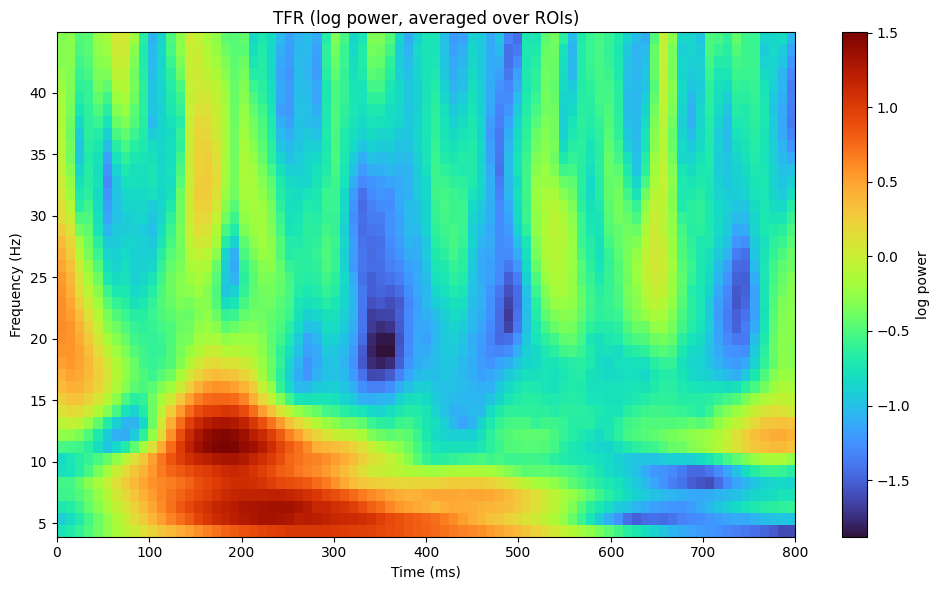

In [9]:
# Average over trials and ROIs
pow_avg = np.nanmean(tensor_norm, axis=(0))  # [Freq x Time]

plt.figure(figsize=(10, 6))
plt.imshow(pow_avg, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('TFR (log power, averaged over ROIs)')
plt.colorbar(label='log power')
plt.axvline(0, color='white', linestyle='--')
plt.tight_layout()
plt.show()

In [10]:
pow_norm = tensor_norm.copy()

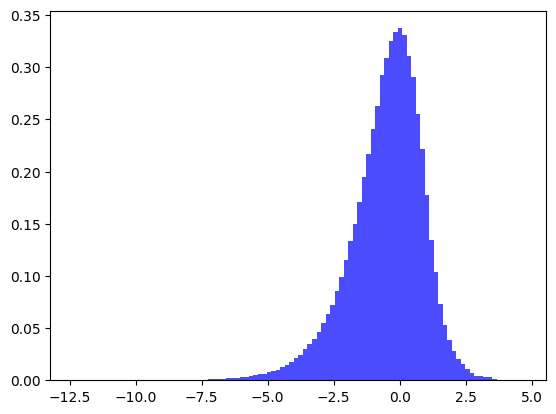

In [24]:
plt.hist(pow_norm.ravel(), bins=100, density=True, color='blue', alpha=0.7);

In [14]:
%cd Tensor-Decompositions-OPM-MEG/

/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [15]:
from src.tools.rankselection import rank_selection, r_squared,  run_parafac

In [17]:
%cd ..

/content/drive/MyDrive/OPM-MEG


In [18]:
def load_aal3_labels(txt_path, n_rois=None):
    """
    Load AAL3 atlas labels from text file.

    Parameters:
        txt_path : str
            Path to label file
        n_rois : int, optional
            If provided, only return first n_rois labels (to match tensor size)

    Returns:
        labels : list of str
    """
    labels = []

    with open(txt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) >= 2:
                labels.append(parts[1])

    # Truncate if needed
    if n_rois is not None:
        if n_rois < len(labels):
            print(f"Truncating labels from {len(labels)} to {n_rois}")
            print(f"Excluded ROIs: {labels[n_rois:]}")
            labels = labels[:n_rois]

    print(f"Loaded {len(labels)} AAL2 labels")
    return labels

aal2_full = load_aal3_labels('aal2.nii.txt')



print(len(aal2_full))


Loaded 120 AAL2 labels
120


In [80]:
# Check shape
print(f"tensor_norm shape: {pow_norm.shape}")
print(f"Number of ROI labels: {len(aal2_full)}")

# Define patterns to KEEP
keep_patterns = [ 'amy','hipp','acc','tempor','insula','ofc','frontal','cingulate']

# Find indices to keep
keep_idx = [i for i, name in enumerate(aal2_full)
            if any(pattern in name.lower() for pattern in keep_patterns)]

# Filter tensor [roi x freq x time] on axis 0
pow_norm_filtered = pow_norm[keep_idx, :, :]
labels_filtered = [aal2_full[i] for i in keep_idx]

print(f"Kept {len(keep_idx)} / {len(aal2_full)} ROIs")
print(f"New shape: {pow_norm_filtered.shape}")
print(f"ROIs kept: {labels_filtered}")

tensor_norm shape: (120, 42, 81)
Number of ROI labels: 120
Kept 46 / 120 ROIs
New shape: (46, 42, 81)
ROIs kept: ['Frontal_Sup_2_L', 'Frontal_Sup_2_R', 'Frontal_Mid_2_L', 'Frontal_Mid_2_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_2_L', 'Frontal_Inf_Orb_2_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'OFCmed_L', 'OFCmed_R', 'OFCant_L', 'OFCant_R', 'OFCpost_L', 'OFCpost_R', 'OFClat_L', 'OFClat_R', 'Insula_L', 'Insula_R', 'Cingulate_Ant_L', 'Cingulate_Ant_R', 'Cingulate_Mid_L', 'Cingulate_Mid_R', 'Cingulate_Post_L', 'Cingulate_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R']


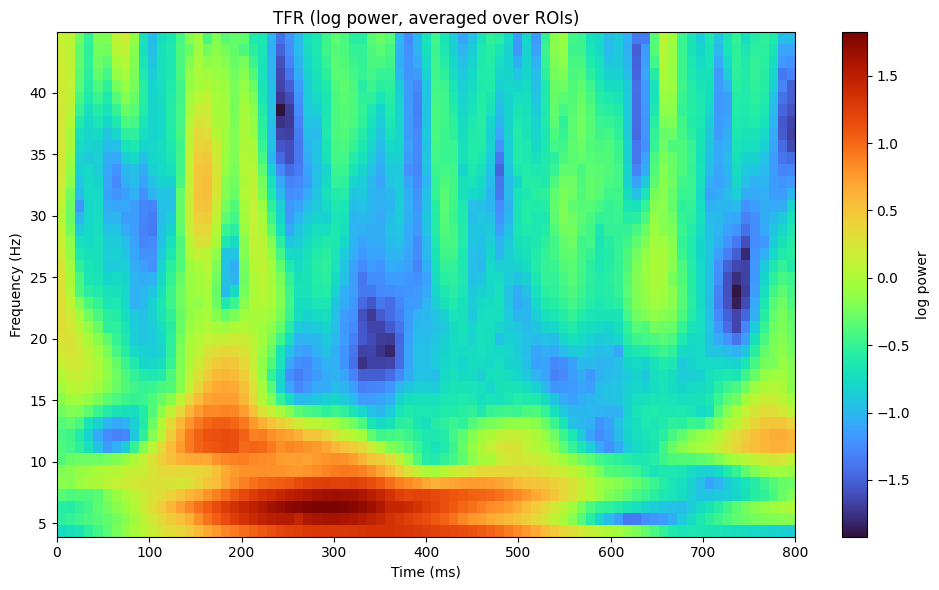

In [96]:
# Average over trials and ROIs
pow_avg = np.nanmean(pow_norm_filtered, axis=(0))  # [Freq x Time]

plt.figure(figsize=(10, 6))
plt.imshow(pow_avg, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('TFR (log power, averaged over ROIs)')
plt.colorbar(label='log power')
plt.axvline(0, color='white', linestyle='--')
plt.tight_layout()
plt.show()

In [81]:
pow_norm_filtered.shape

(46, 42, 81)

In [82]:
pow_positive = np.maximum(pow_norm_filtered, 0)  # ERS only
pow_negative = np.abs(np.minimum(pow_norm_filtered, 0))  # ERD only (make positive)

In [94]:
plt.hist(pow_positive.ravel(), bins=100, density=True, color='blue', alpha=0.7);

In [95]:
plt.hist(pow_negative.ravel(), bins=100, density=True, color='blue', alpha=0.7);

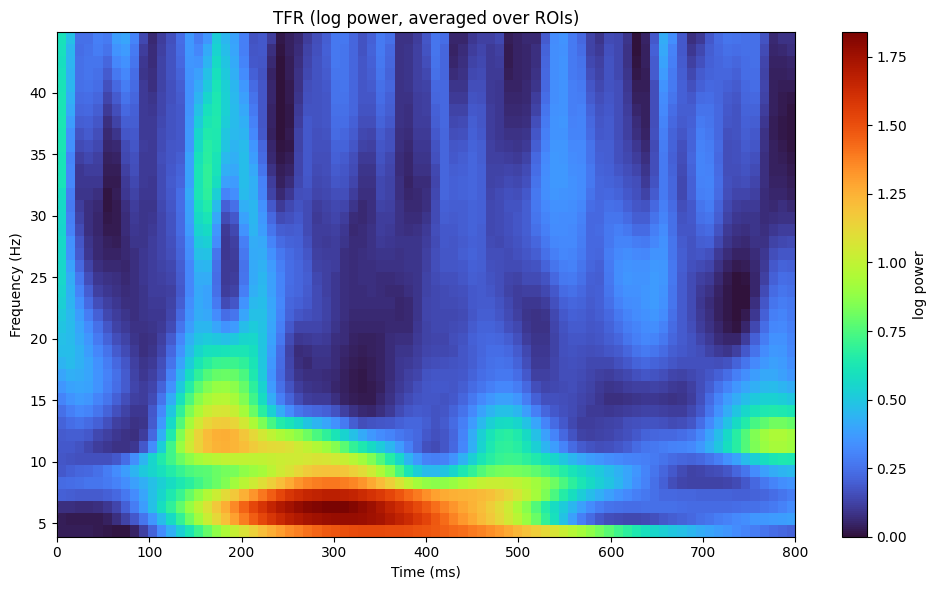

In [113]:
# Average over trials and ROIs
pow_avg = np.nanmean(pow_positive, axis=(0))  # [Freq x Time]

plt.figure(figsize=(10, 6))
plt.imshow(pow_avg, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('TFR (log power, averaged over ROIs)')
plt.colorbar(label='log power')
plt.axvline(0, color='white', linestyle='--')
plt.tight_layout()
plt.show()

In [114]:
# Average over trials and ROIs
pow_avg = np.nanmean(pow_negative, axis=(0))  # [Freq x Time]

plt.figure(figsize=(10, 6))
plt.imshow(pow_avg, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('TFR (log power, averaged over ROIs)')
plt.colorbar(label='log power')
plt.axvline(0, color='white', linestyle='--')
plt.tight_layout()
plt.show()

In [86]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pos_pow_torch = torch.as_tensor(pow_positive, device=device, dtype=torch.float32)
pos_pow_torch.shape[0]

46

In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
neg_pow_torch = torch.as_tensor(pow_negative, device=device, dtype=torch.float32)
neg_pow_torch.shape[0]

46

In [45]:
results = rank_selection(pos_pow_torch, ranks=range(1, 16), n_repeats=30)


=== Rank 1 ===
--- Testing Rank 1 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 1: Best Error=0.7401 | Mean Stability=1.0000
Rank 1: Stability=1.000±0.000, R²=0.276±0.000

=== Rank 2 ===
--- Testing Rank 2 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 2: Best Error=0.6504 | Mean Stability=1.0000
Rank 2: Stability=1.000±0.000, R²=0.441±0.000

=== Rank 3 ===
--- Testing Rank 3 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 3: Best Error=0.6246 | Mean Stability=0.7406
Rank 3: Stability=0.741±0.260, R²=0.484±0.000

=== Rank 4 ===
--- Testing Rank 4 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 4: Best Error=0.5988 | Mean Stability=0.8914
Rank 4: Stability=0.891±0.215, R²=0.526±0.000

=== Rank 5 ===
--- Testing Rank 5 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 5: Best Error=0.5706 | Mean Stability=0.9581
Rank 5: Stability=0.958±0.157, R²=0.569±0.003

=== Rank 6 ===
--- Testing Rank 6 

In [75]:
stabilities_ers = results['stabilities']
stds_ers = results['stab_stds']

ranks_ers = results['ranks']
r2_scores_ers = results['r2_scores']
r2_stds_ers = results['r2_stds']

In [227]:
print(stabilities_ers)
print(stds_ers)
print(ranks_ers)
print(r2_scores_ers)
print(r2_stds_ers)

[np.float32(1.0000002), np.float32(0.9999662), np.float32(0.7405536), np.float32(0.8913753), np.float32(0.9581177), np.float32(0.83525085), np.float32(0.6365898), np.float32(0.63047594), np.float32(0.419717), np.float32(0.3538057), np.float32(0.3501306), np.float32(0.3386576), np.float32(0.29885623), np.float32(0.28404063), np.float32(0.27378994)]
[np.float32(9.973765e-08), np.float32(5.405303e-05), np.float32(0.2604916), np.float32(0.21482764), np.float32(0.15689985), np.float32(0.24446239), np.float32(0.16506928), np.float32(0.2529854), np.float32(0.14955847), np.float32(0.1471061), np.float32(0.1833659), np.float32(0.15019804), np.float32(0.14978087), np.float32(0.15253639), np.float32(0.14457963)]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0.2756783366203308, 0.4406924247741699, 0.48406660556793213, 0.5259273052215576, 0.5694887042045593, 0.6029295921325684, 0.6312294006347656, 0.6601963043212891, 0.6859471797943115, 0.7078531980514526, 0.7257934808731079, 0.7430294752120

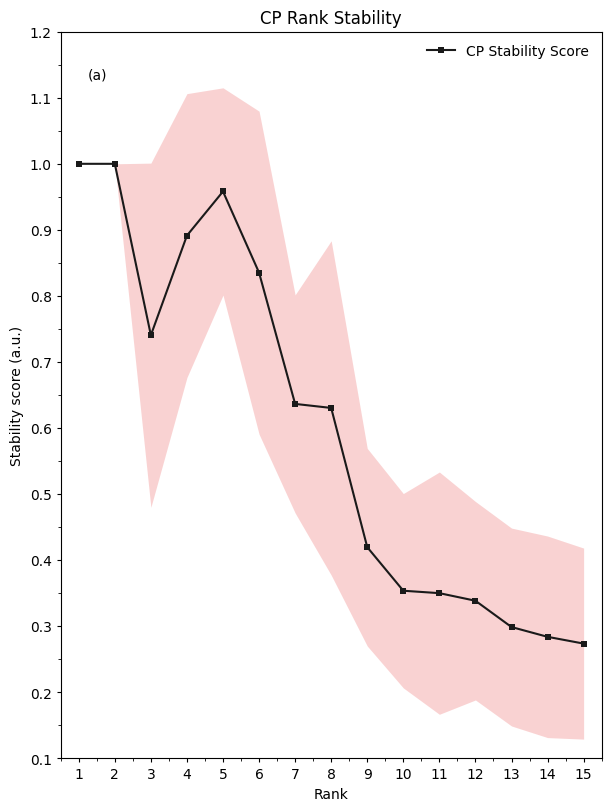

In [76]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(
    figsize=(6, 8),
    constrained_layout=True
)

def panel(a, y, yerr, title, panel_label, ranks):
    # Uncertainty as a band
    a.fill_between(
        ranks, y - yerr, y + yerr,
        color="lightcoral", alpha=0.35, linewidth=0, zorder=1
    )

    # Mean line + markers
    a.plot(
        ranks, y, "s-",
        color="0.1",
        markersize=4,
        markerfacecolor="0.1",
        markeredgewidth=0,
        zorder=2,
        label="Stability Score - ALS"
    )

    # Reference line
   # a.axhline(0.6, color="0.5", ls="--", lw=0.8, zorder=0)

    # Axes formatting
    a.set_title(title)
    a.set_xlim(0.5, max(ranks) + 0.5)
    a.set_xticks(ranks)
    a.tick_params(direction="out", length=3, width=0.8)
    a.tick_params(which="minor", direction="out", length=2, width=0.6)

    # Minor ticks without clutter
    a.xaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(0.1))

    # Panel label
    a.text(0.05, 0.95, panel_label, transform=a.transAxes,
           va="top", ha="left")

panel(ax, np.asarray(stabilities_ers), np.asarray(stds_ers),
      "CP Rank Stability", "(a)",ranks_ers)

ax.set_ylabel("Stability score (a.u.)")
ax.set_xlabel("Rank")
ax.set_ylim(0.1, 1.2)

# Legend
ax.legend(loc="upper right", frameon=False)

plt.show()

In [77]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(
    figsize=(6, 8),
    constrained_layout=True
)

def panel(a, y, yerr, title, panel_label, ranks):
    # Uncertainty as a band
    a.fill_between(
        ranks, y - yerr, y + yerr,
        color="lightcoral", alpha=0.35, linewidth=0, zorder=1
    )

    # Mean line + markers
    a.plot(
        ranks, y, "s-",
        color="0.1",
        markersize=4,
        markerfacecolor="0.1",
        markeredgewidth=0,
        zorder=2,
        label=fr"$R^2$ - ALS"
    )

    # Reference line
   # a.axhline(0.6, color="0.5", ls="--", lw=0.8, zorder=0)

    # Axes formatting
    a.set_title(title)
    a.set_xlim(0.5, max(ranks) + 0.5)
    a.set_xticks(ranks)
    a.tick_params(direction="out", length=3, width=0.8)
    a.tick_params(which="minor", direction="out", length=2, width=0.6)

    # Minor ticks without clutter
    a.xaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(0.1))

    # Panel label
    a.text(0.05, 0.95, panel_label, transform=a.transAxes,
           va="top", ha="left")

panel(ax, np.asarray(r2_scores_ers), np.asarray(r2_stds_ers),
      "CP Rank Explained Variance", "(b)", ranks_ers)

ax.set_ylabel(fr"$R^2$")
ax.set_xlabel("Rank")
ax.set_ylim(0.1, 1.02)

# Legend
ax.legend(loc="upper right", frameon=False)

plt.show()

In [53]:
from tensorly.cp_tensor import cp_normalize
from tensorly.decomposition import parafac
import tensorly as tl
tl.set_backend('pytorch')

In [56]:
%pwd

'/content/drive/MyDrive/OPM-MEG'

In [55]:
aal_nifti_path = 'AAL3v1_1mm.nii'

In [214]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
from matplotlib.gridspec import GridSpec

def to_numpy(x):
    """Safely converts PyTorch Tensors to NumPy arrays."""
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    elif hasattr(x, "numpy"):
        return x.numpy()
    return np.array(x)

def plot_factors_on_atlas_ers_erd(
    A,B,C,
    roi_labels, full_atlas_labels, aal_nifti_path,
    freq_vec=None, time_vec=None,
    top_n_rois=10,
    threshold_percentile=75,
    plot_type='ERS',  # 'ERS' or 'ERD'
    time_in_seconds=True,
    save_fig = False,
    filename=None
):
    """
    Plots CP factors using Nilearn with ERS/ERD specific logic.
    ERS uses Red themes; ERD uses Blue themes.
    """
    # Extract A, B, C from the Parafac object
    A = to_numpy(A)
    B = to_numpy(B)
    C = to_numpy(C)

    aal_img = nib.load(aal_nifti_path)
    aal_data = aal_img.get_fdata()
    affine = aal_img.affine

    R = A.shape[1]

    # Define theme colours based on input
    main_color = 'red' if plot_type == 'ERS' else 'blue'
    cmap = 'Reds' if plot_type == 'ERS' else 'Blues'

    if freq_vec is None:
        freq_vec = np.linspace(0, 45, B.shape[0])
    else:
        freq_vec = to_numpy(freq_vec)

    if time_vec is None:
        time_vec = np.linspace(0, 1000, C.shape[0])
    else:
        time_vec = to_numpy(time_vec)
        if time_in_seconds:
            time_vec *= 1000

    for r in range(R):
        fig = plt.figure(figsize=(18, 8))
        gs = GridSpec(
            2, 4, figure=fig,
            height_ratios=[1, 0.8],
            width_ratios=[1.2, 1, 1, 1],
            hspace=0.3, wspace=0.3,
        )

        title_color = 'red' if plot_type == 'ERS' else 'blue'
        fig.suptitle(f"{plot_type} Component {r+1}", fontsize=16, fontweight="bold", color=title_color)

        # Spatial Factor (A)
        roi_weights = np.nan_to_num(A[:, r].copy(), nan=0.0)

        abs_weights = np.abs(roi_weights)
        max_abs = np.max(abs_weights)
        roi_weights_norm = abs_weights / max_abs if max_abs > 0 else abs_weights

        brain_vol = np.zeros(aal_data.shape, dtype=float)
        for i, roi_name in enumerate(roi_labels):
            try:
                atlas_idx = full_atlas_labels.index(roi_name)
                brain_vol[aal_data == atlas_idx + 1] = roi_weights_norm[i]
            except ValueError:
                pass

        weight_nii = nib.Nifti1Image(brain_vol, affine)
        nonzero = roi_weights_norm[roi_weights_norm != 0]
        threshold = np.percentile(nonzero, threshold_percentile) if len(nonzero) > 0 else 0.01

        # --- GLASS BRAIN ---
        ax_glass = fig.add_subplot(gs[0, 0])
        plotting.plot_glass_brain(
            weight_nii,
            axes=ax_glass,
            display_mode="lyrz",
            threshold=threshold,
            colorbar=True,
            plot_abs=True,
            vmax=1.0,
            cmap=cmap,
            alpha=0.8,
        )
        ax_glass.set_title(f"Glass Brain ({plot_type})")

        # --- AXIAL SLICES ---
        ax_stat = fig.add_subplot(gs[0, 1:])
        plotting.plot_stat_map(
            weight_nii,
            axes=ax_stat,
            display_mode="z",
            cut_coords=7,
            threshold=threshold,
            colorbar=True,
            vmax=1.0,
            cmap=cmap,
        )

        # --- TOP ROIs (Bar Chart) ---
        ax_bar = fig.add_subplot(gs[1, 0])
        sorted_idx = np.argsort(abs_weights)[::-1]
        top_idx = sorted_idx[:top_n_rois]
        top_weights = abs_weights[top_idx]
        top_names = [roi_labels[i][:20] for i in top_idx]

        y_pos = np.arange(len(top_weights))
        ax_bar.barh(y_pos, top_weights, color=main_color, alpha=0.7, edgecolor="black")
        ax_bar.set_yticks(y_pos)
        ax_bar.set_yticklabels(top_names, fontsize=9)
        ax_bar.set_title(f"Top {top_n_rois} {plot_type} ROIs")
        ax_bar.invert_yaxis()

        # --- FREQUENCY (Spectral Factor B) ---
        ax_freq = fig.add_subplot(gs[1, 1:3])
        freq_weights = np.abs(B[:, r])
        ax_freq.fill_between(freq_vec, freq_weights, alpha=0.3, color=main_color)
        ax_freq.plot(freq_vec, freq_weights, linewidth=2, color=main_color)
        ax_freq.set_title(f"{plot_type} Frequency Profile")
        ax_freq.set_xlabel("Frequency (Hz)")

        # Mark frequency bands
        bands = {'δ': (1, 4), 'θ': (4, 8), 'α': (8, 13), 'β': (13, 30), 'γ': (30, 45)}
        for band_name, (f_low, f_high) in bands.items():
            f_mid = (f_low + f_high) / 2
            if freq_vec.min() <= f_mid <= freq_vec.max():
                ax_freq.axvspan(f_low, f_high, alpha=0.1, color='gray')
                ax_freq.text(f_mid, ax_freq.get_ylim()[1] * 0.95, band_name,
                           ha='center', fontsize=8, alpha=0.7)

        # --- TIME (Temporal Factor C) ---
        ax_time = fig.add_subplot(gs[1, 3])
        time_weights = np.abs(C[:, r])
        ax_time.fill_between(time_vec, time_weights, alpha=0.3, color=main_color)
        ax_time.plot(time_vec, time_weights, linewidth=1.5, color=main_color)
        ax_time.set_title(f"{plot_type} Temporal Profile")
        ax_time.set_xlabel("Time (ms)")

        if save_fig:
          plt.savefig(filename + f'Component {r+1}.svg')


        plt.tight_layout()
        plt.show()


In [222]:
cp_tensor_ers = parafac(pos_pow_torch, rank=12,n_iter_max=10000,init='svd',tol=1e-9,normalize_factors=True)
weights_ers, factors_ers = cp_tensor_ers


In [223]:
weights_np_ers = weights_ers.to('cpu').numpy().copy()
args = np.argsort(weights_np_ers)

factors_np_ers = [f.to('cpu').numpy().copy() for f in factors_ers]

A_ers, B_ers, C_ers = factors_np_ers

A_ers_sorted = A_ers[:,args]
B_ers_sorted = B_ers[:,args]
C_ers_sorted = C_ers[:,args]

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


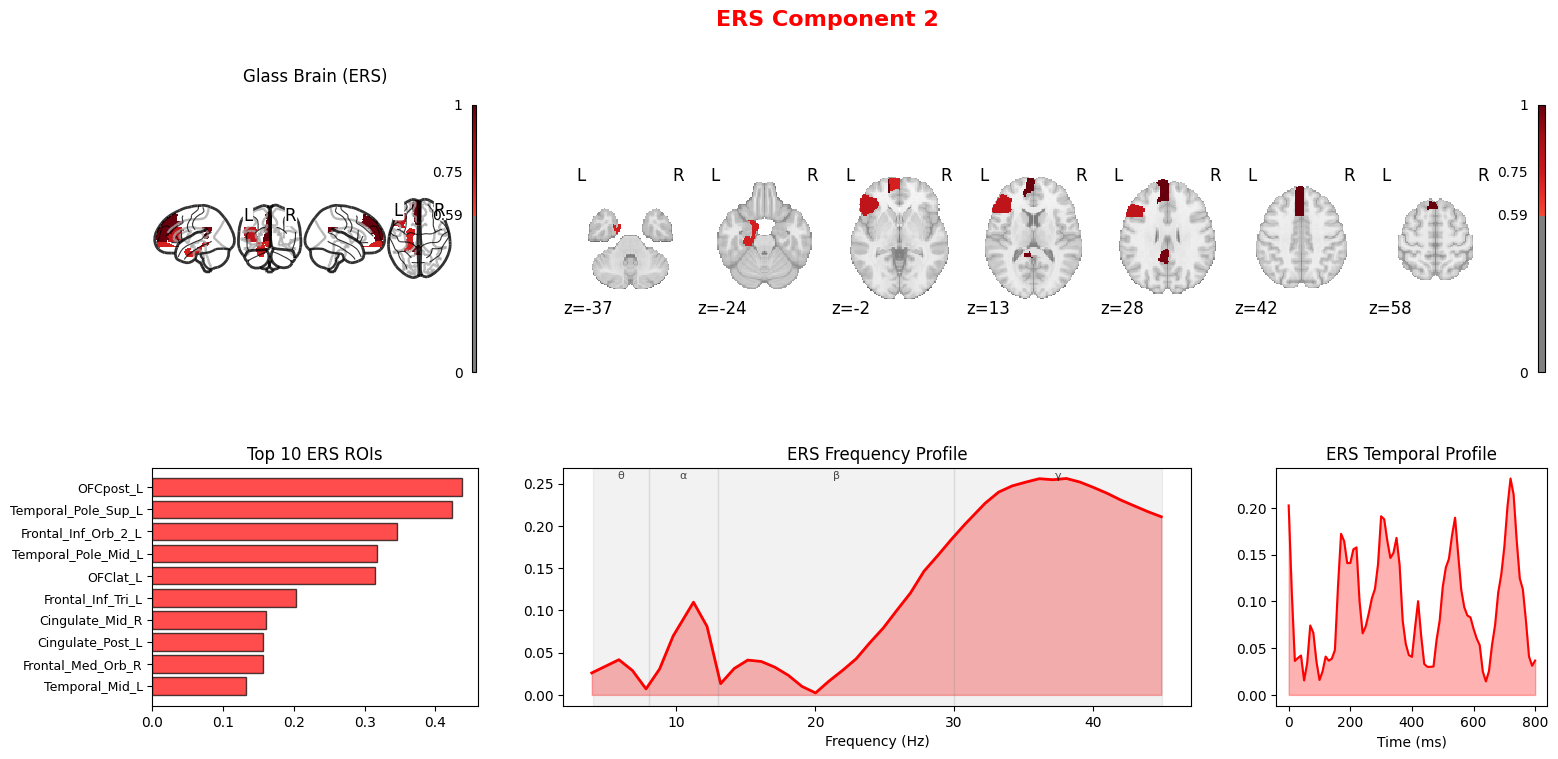

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


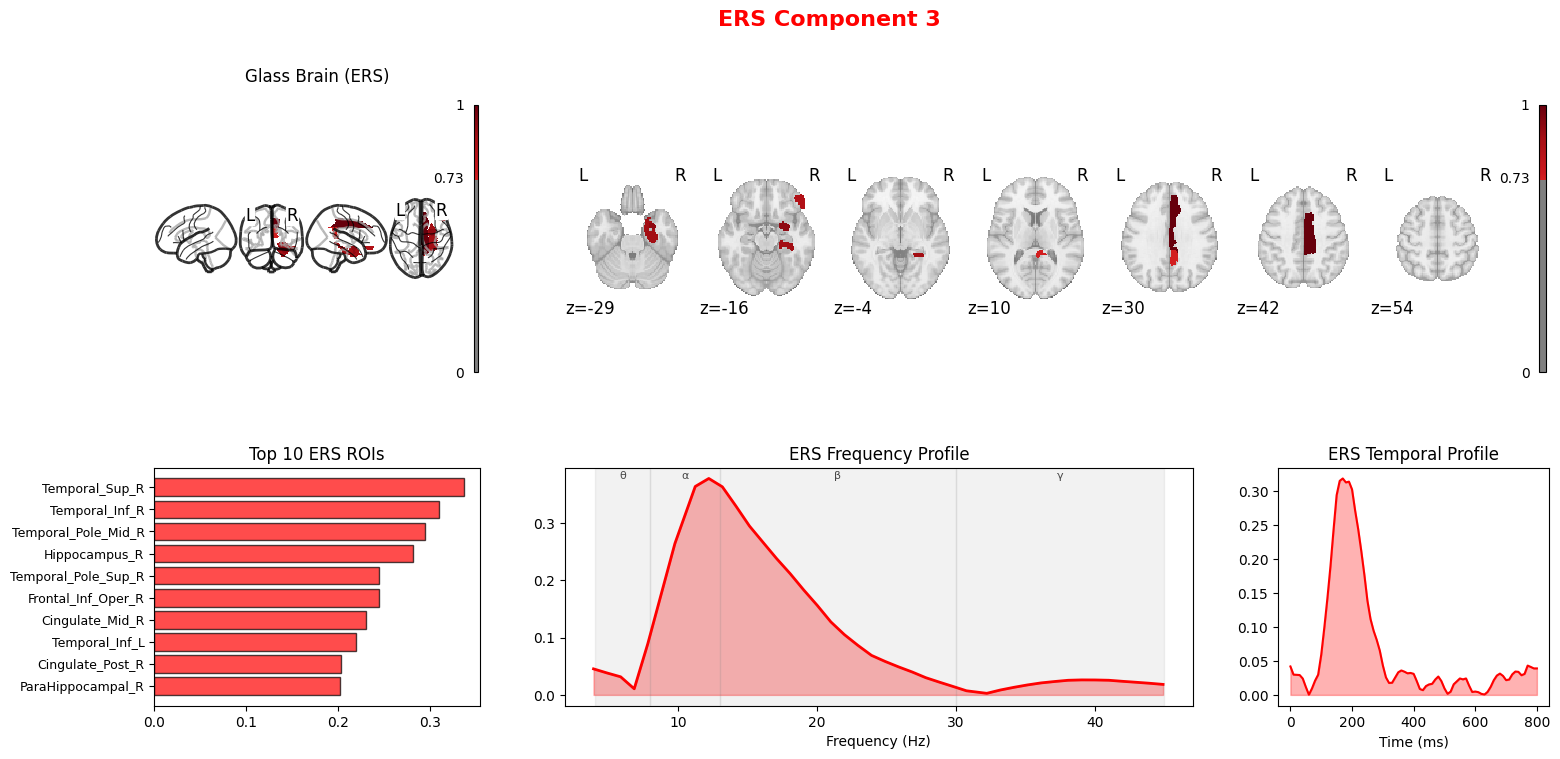

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


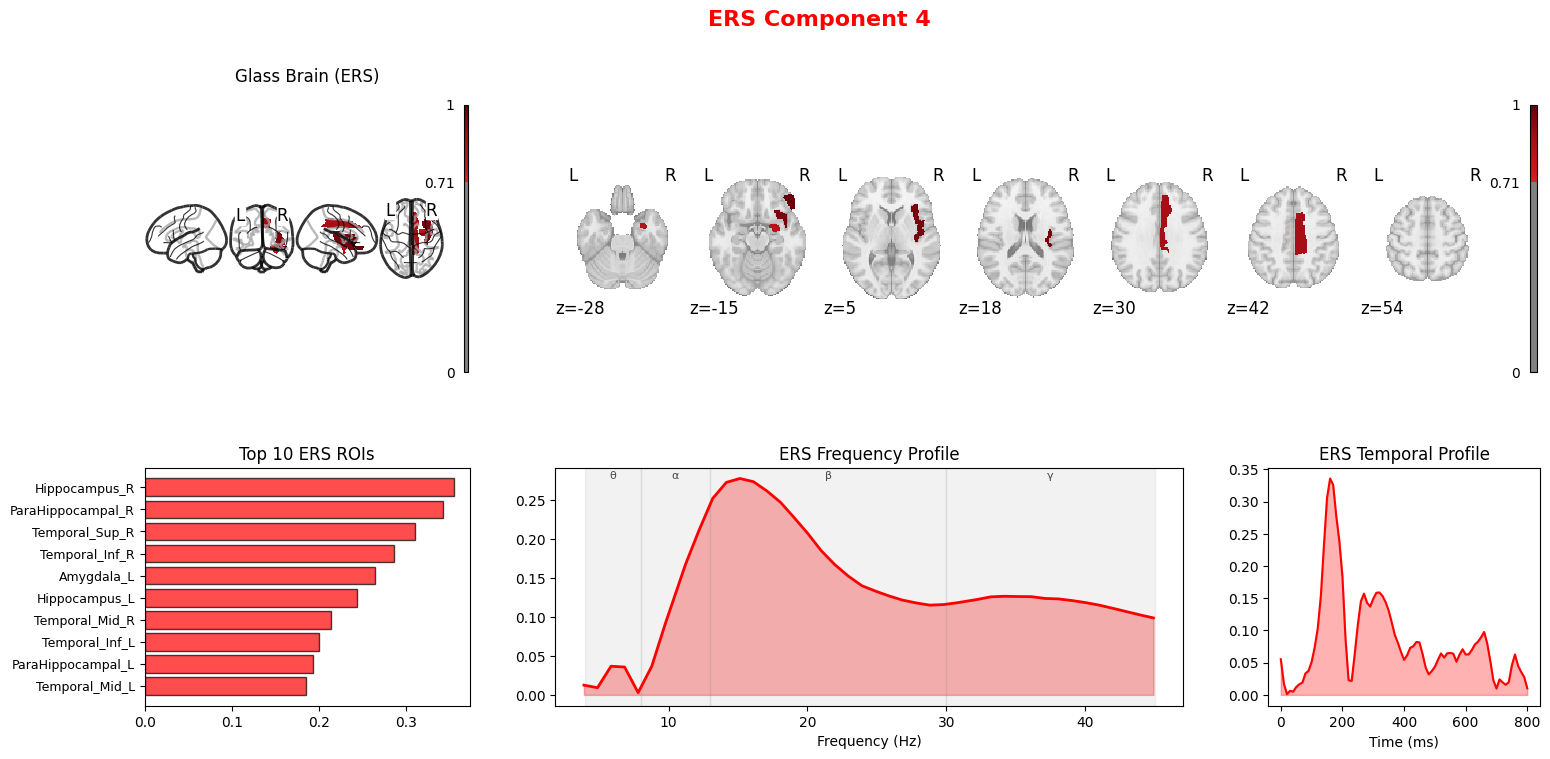

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


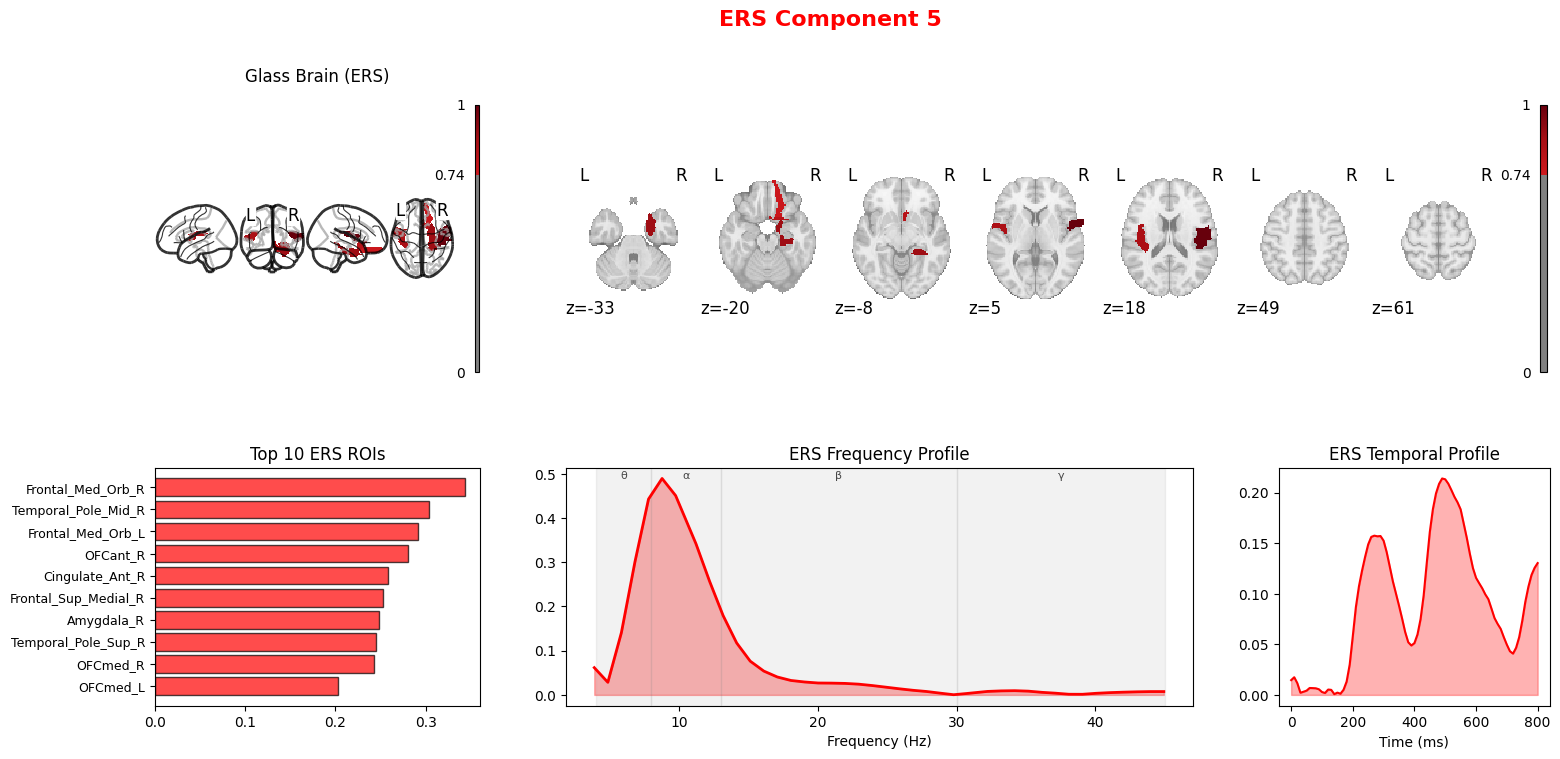

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


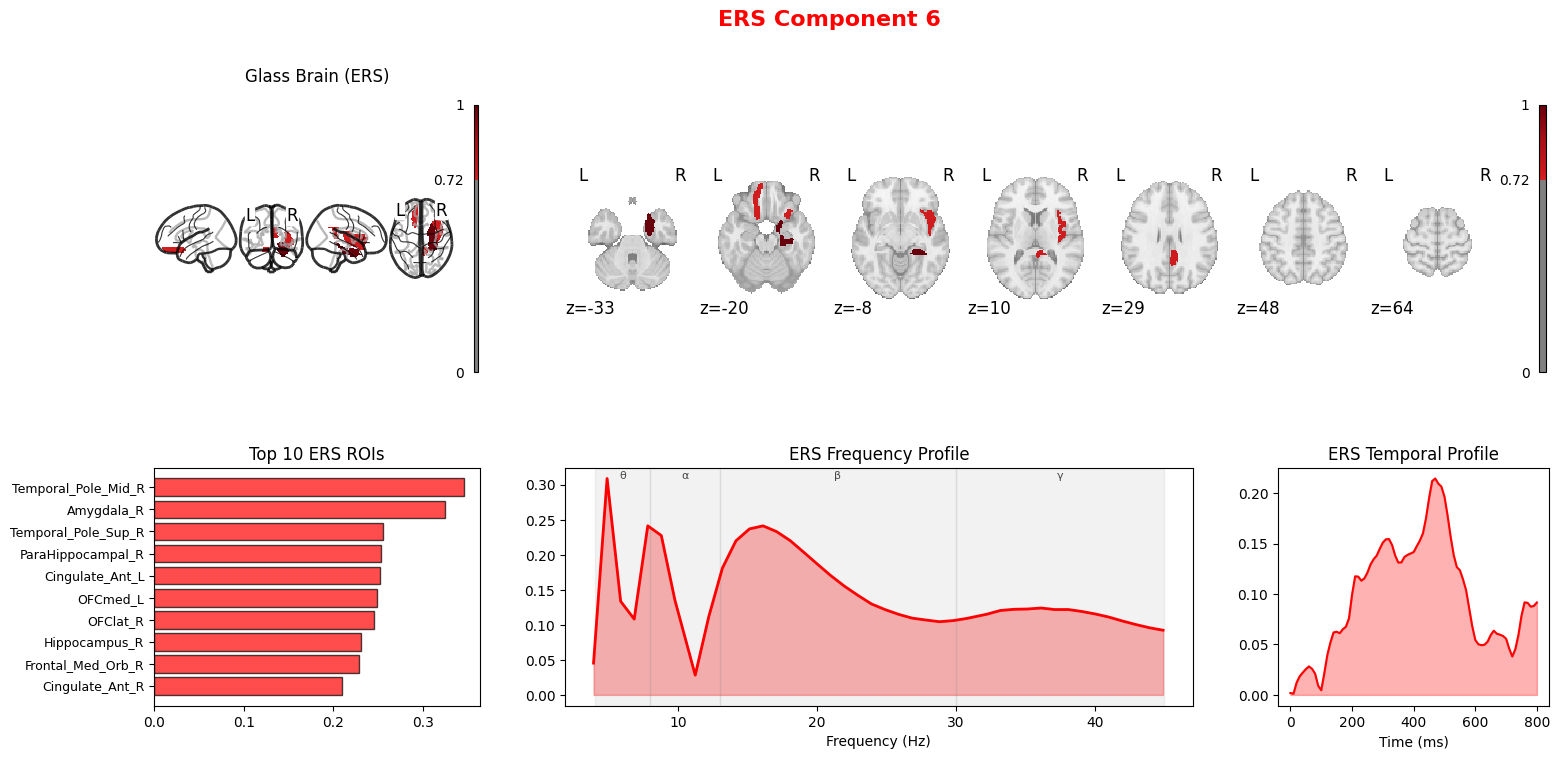

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


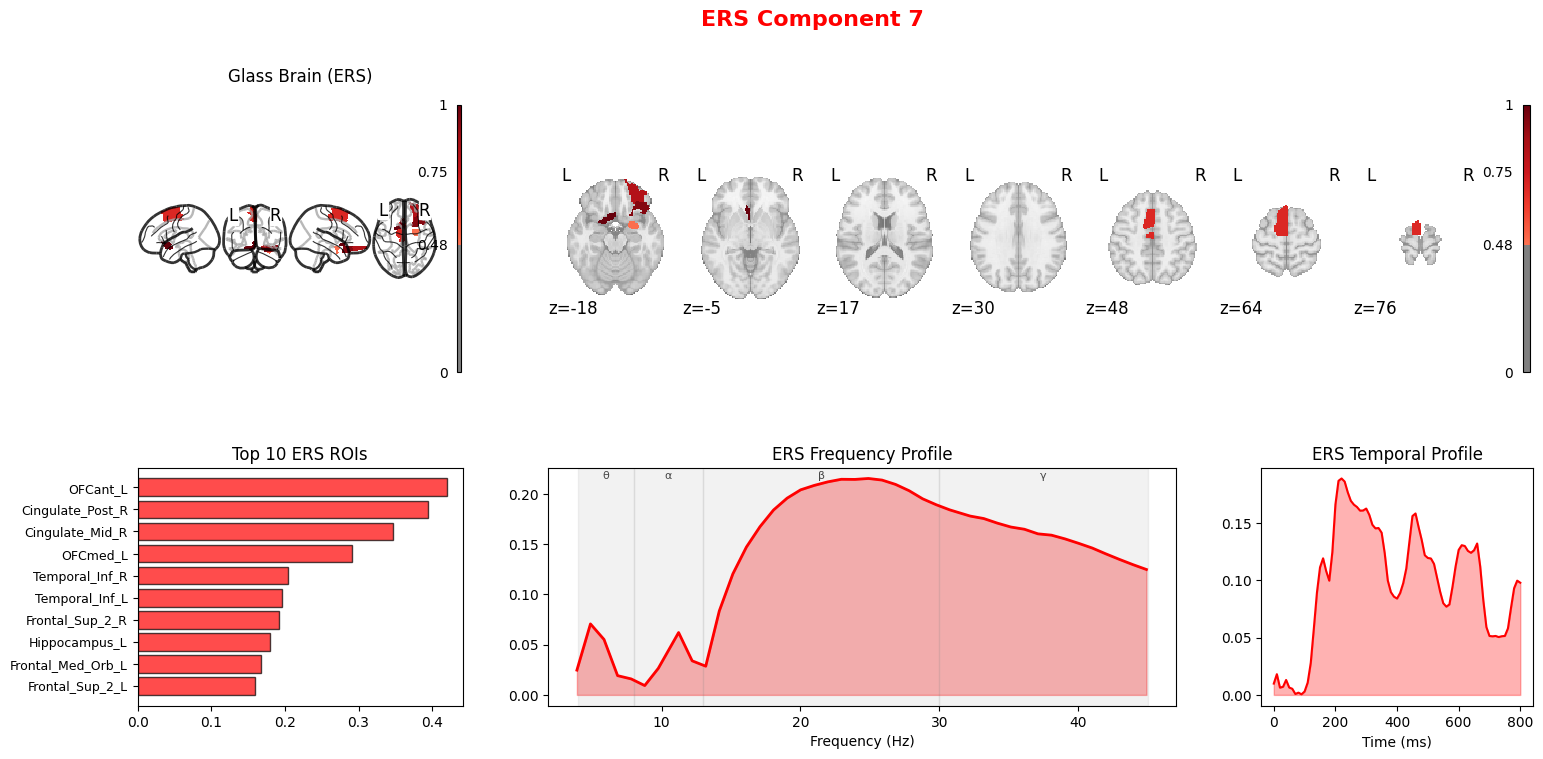

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


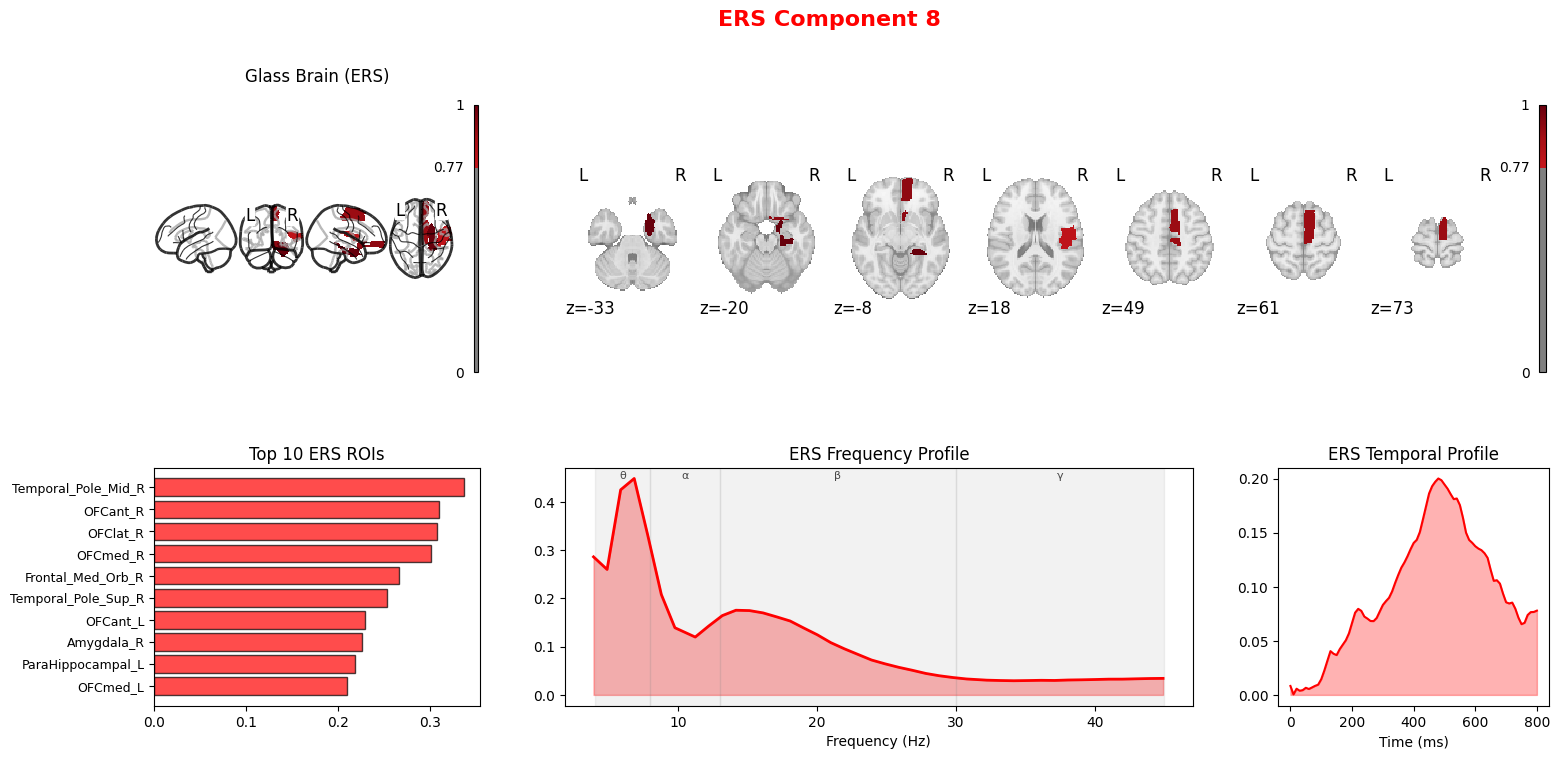

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


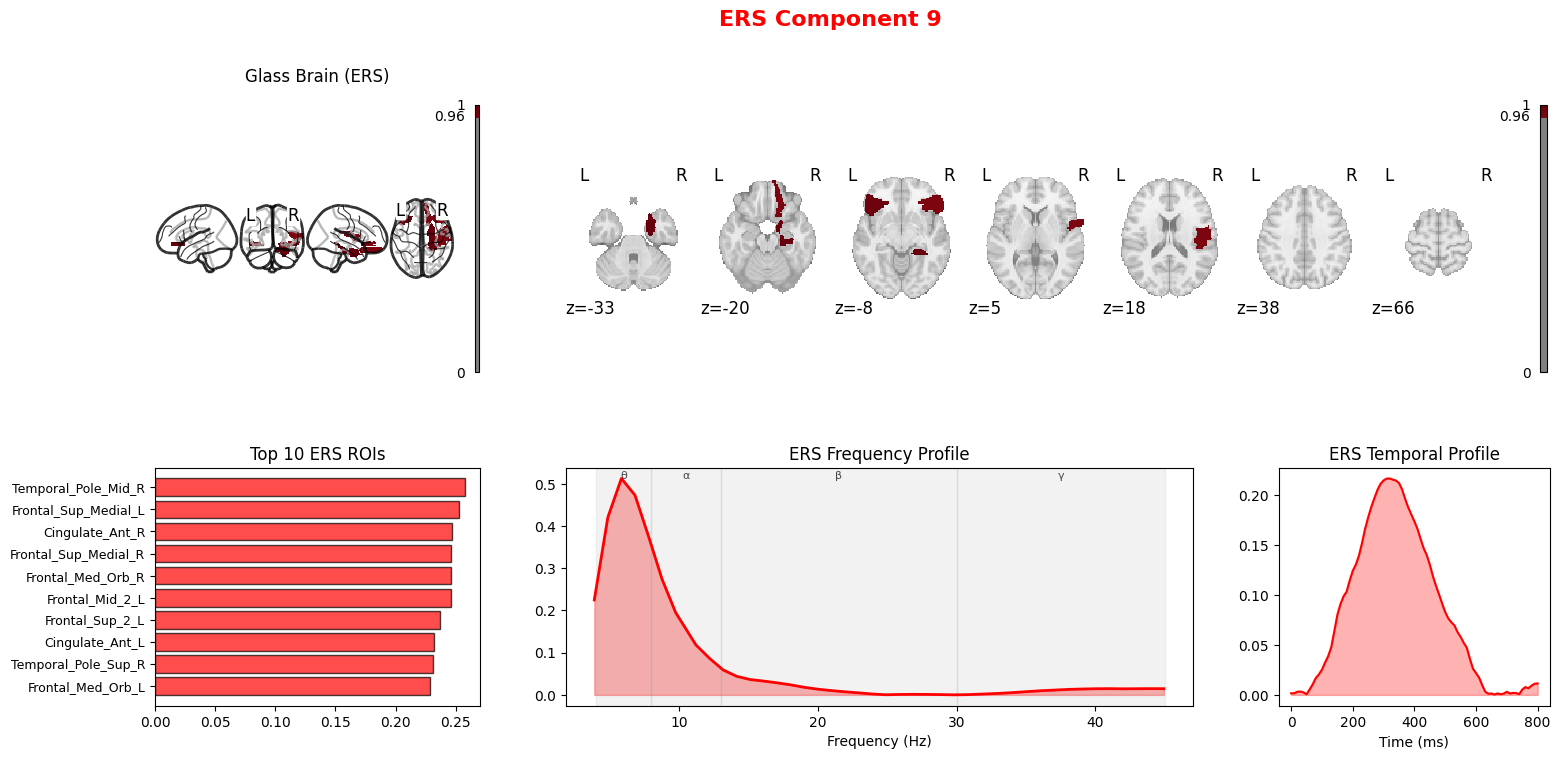

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


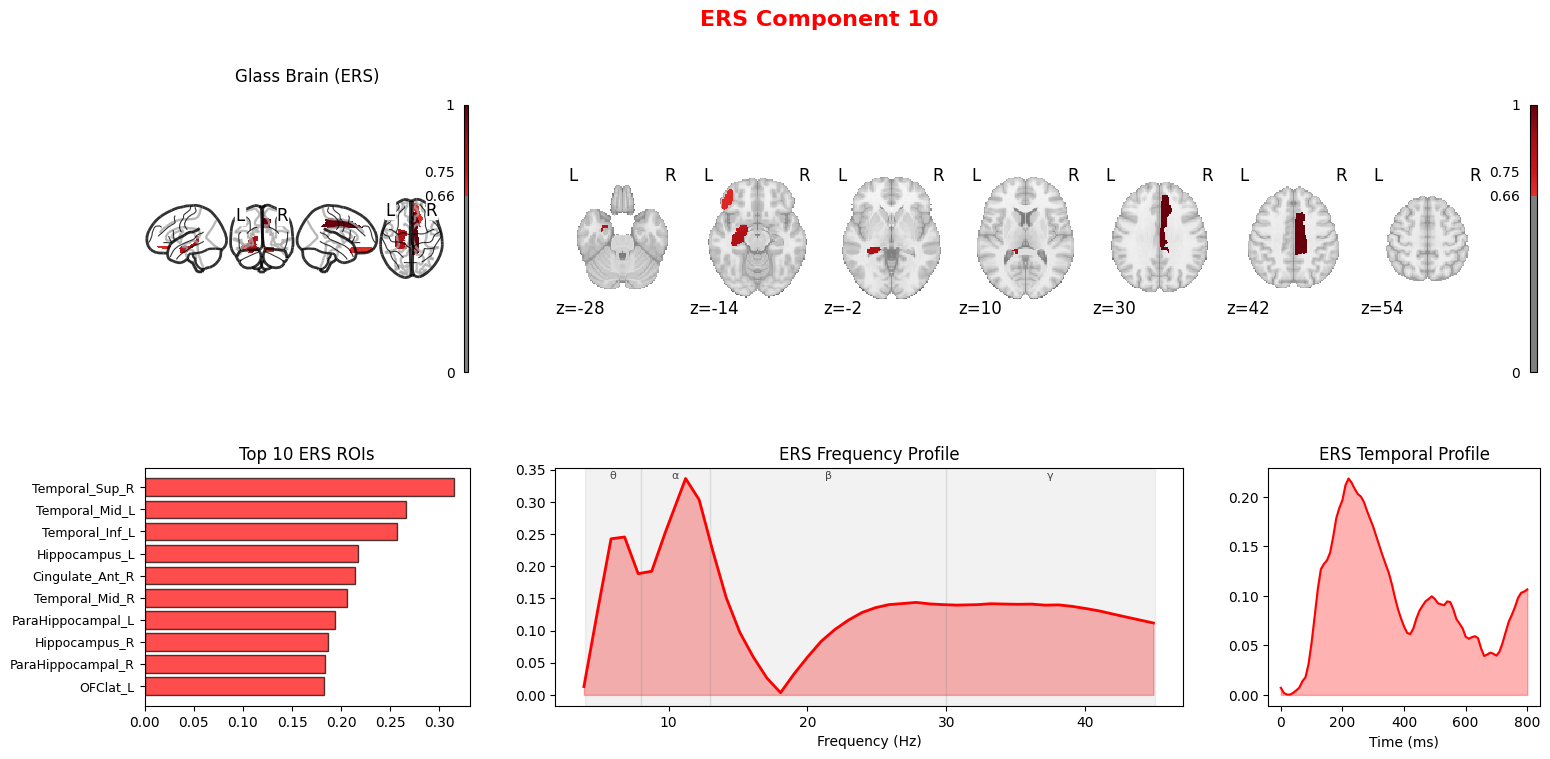

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


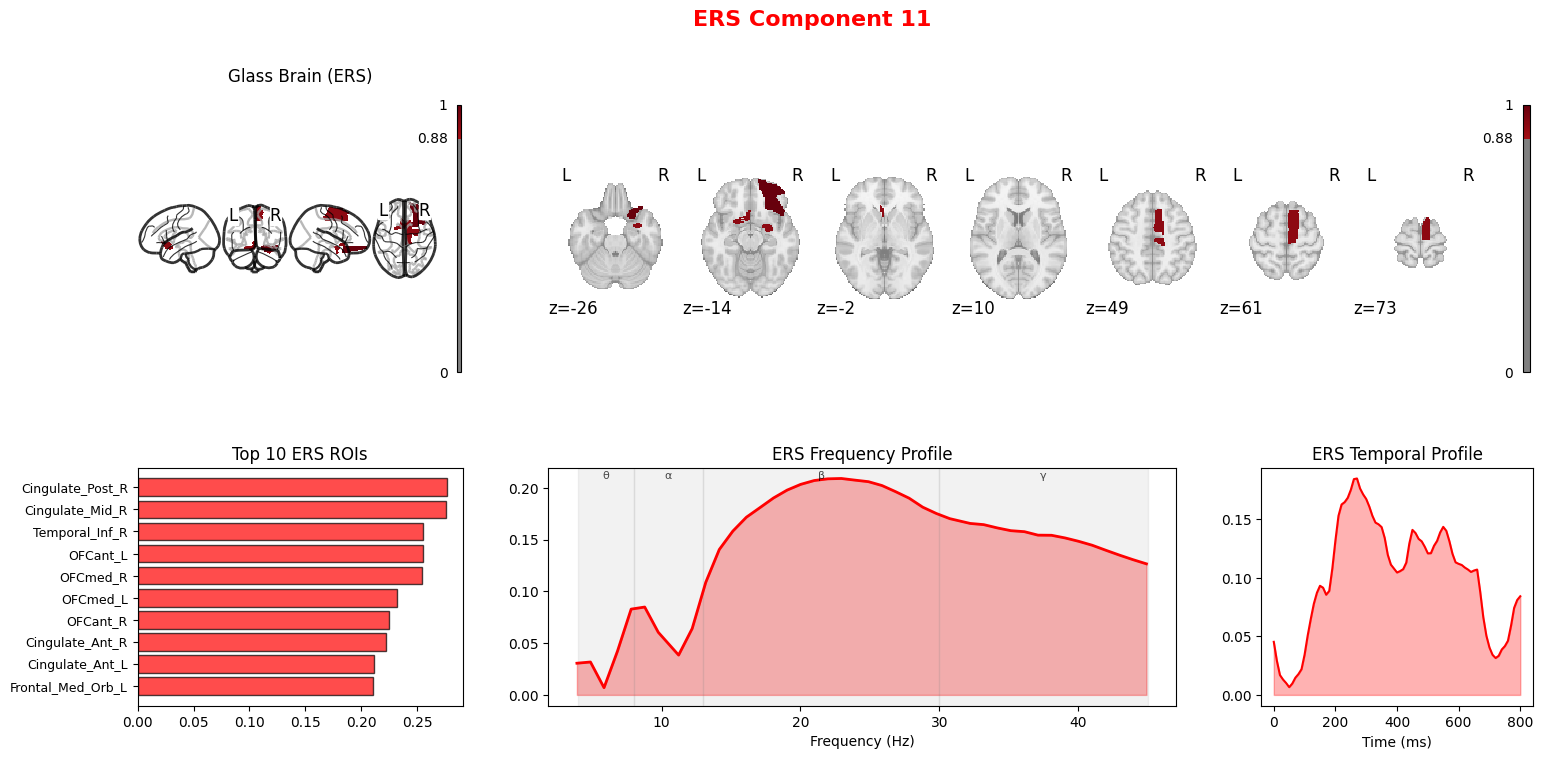

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [224]:
plot_factors_on_atlas_ers_erd(A_ers_sorted,B_ers_sorted,C_ers_sorted, labels_filtered, labels_filtered, aal_nifti_path, freq_vec,time_vec, plot_type='ERS',threshold_percentile=90, save_fig=1,filename='outcome_alltrials_ers' )

In [97]:
results = rank_selection(neg_pow_torch, ranks=range(1, 16), n_repeats=30)


=== Rank 1 ===
--- Testing Rank 1 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 1: Best Error=0.7859 | Mean Stability=1.0000
Rank 1: Stability=1.000±0.000, R²=0.075±0.000

=== Rank 2 ===
--- Testing Rank 2 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 2: Best Error=0.7667 | Mean Stability=0.9989
Rank 2: Stability=0.999±0.001, R²=0.120±0.000

=== Rank 3 ===
--- Testing Rank 3 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 3: Best Error=0.7477 | Mean Stability=0.4391
Rank 3: Stability=0.439±0.275, R²=0.163±0.001

=== Rank 4 ===
--- Testing Rank 4 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 4: Best Error=0.7307 | Mean Stability=0.7256
Rank 4: Stability=0.726±0.279, R²=0.201±0.002

=== Rank 5 ===
--- Testing Rank 5 with 30 repeats ---
  30/30 models within 1.05x of best error
Rank 5: Best Error=0.7145 | Mean Stability=0.7766
Rank 5: Stability=0.777±0.195, R²=0.236±0.002

=== Rank 6 ===
--- Testing Rank 6 

In [98]:
stabilities_erd = results['stabilities']
stds_erd = results['stab_stds']

ranks_erd = results['ranks']
r2_scores_erd = results['r2_scores']
r2_stds_erd = results['r2_stds']

In [228]:
print(stabilities_erd)
print(stds_erd)
print(ranks_erd)
print(r2_scores_erd)
print(r2_stds_erd)

[np.float32(1.0), np.float32(0.9989146), np.float32(0.43911135), np.float32(0.7256244), np.float32(0.77661824), np.float32(0.6646337), np.float32(0.5064456), np.float32(0.5890944), np.float32(0.5966713), np.float32(0.4391113), np.float32(0.21076186), np.float32(0.23336877), np.float32(0.3110336), np.float32(0.28729454), np.float32(0.34840155)]
[np.float32(1.3149096e-07), np.float32(0.00067843613), np.float32(0.2748358), np.float32(0.27947083), np.float32(0.19506237), np.float32(0.2553794), np.float32(0.25067103), np.float32(0.29674515), np.float32(0.2433217), np.float32(0.19528742), np.float32(0.16897953), np.float32(0.15975502), np.float32(0.14290002), np.float32(0.1534106), np.float32(0.14149536)]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0.07536602020263672, 0.12015849351882935, 0.16307693719863892, 0.20067250728607178, 0.23572838306427002, 0.2673344016075134, 0.2964159846305847, 0.32485032081604004, 0.35135865211486816, 0.37605583667755127, 0.40022552013397217, 0.4227281

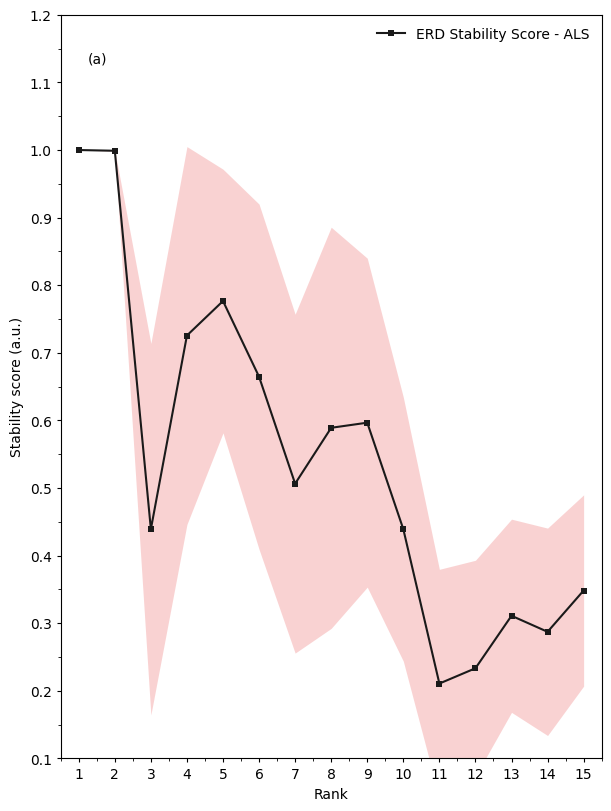

In [110]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(
    figsize=(6, 8),
    constrained_layout=True
)

def panel(a, y, yerr, title, panel_label, ranks):
    # Uncertainty as a band
    a.fill_between(
        ranks, y - yerr, y + yerr,
        color="lightcoral", alpha=0.35, linewidth=0, zorder=1
    )

    # Mean line + markers
    a.plot(
        ranks, y, "s-",
        color="0.1",
        markersize=4,
        markerfacecolor="0.1",
        markeredgewidth=0,
        zorder=2,
        label="ERD Stability Score - ALS"
    )

    # Reference line
   # a.axhline(0.6, color="0.5", ls="--", lw=0.8, zorder=0)

    # Axes formatting
    #a.set_title(title)
    a.set_xlim(0.5, max(ranks) + 0.5)
    a.set_xticks(ranks)
    a.tick_params(direction="out", length=3, width=0.8)
    a.tick_params(which="minor", direction="out", length=2, width=0.6)

    # Minor ticks without clutter
    a.xaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(0.1))

    # Panel label
    a.text(0.05, 0.95, panel_label, transform=a.transAxes,
           va="top", ha="left")

panel(ax, np.asarray(stabilities_erd), np.asarray(stds_erd),
      "CP Rank Stability", "(a)",ranks_erd)

ax.set_ylabel("Stability score (a.u.)")
ax.set_xlabel("Rank")
ax.set_ylim(0.1, 1.2)

# Legend
ax.legend(loc="upper right", frameon=False)

plt.show()

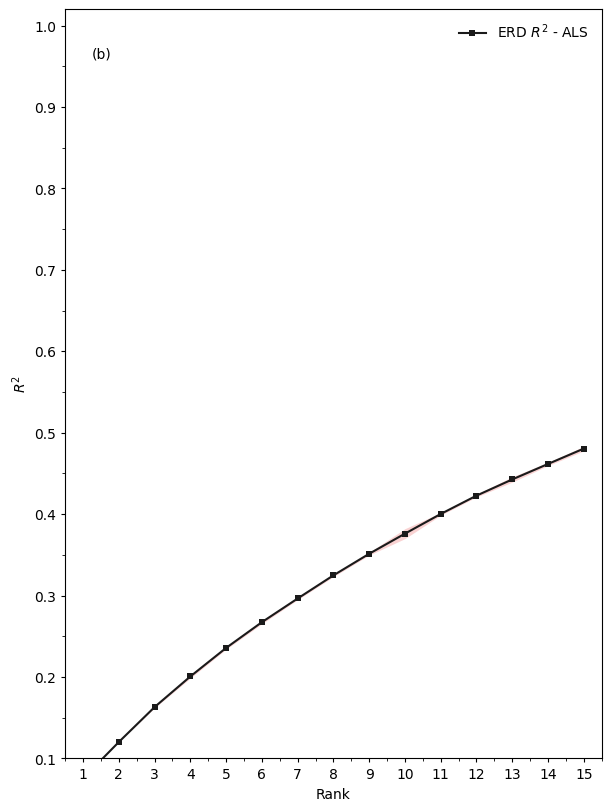

In [109]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(
    figsize=(6, 8),
    constrained_layout=True
)

def panel(a, y, yerr, title, panel_label, ranks):
    # Uncertainty as a band
    a.fill_between(
        ranks, y - yerr, y + yerr,
        color="lightcoral", alpha=0.35, linewidth=0, zorder=1
    )

    # Mean line + markers
    a.plot(
        ranks, y, "s-",
        color="0.1",
        markersize=4,
        markerfacecolor="0.1",
        markeredgewidth=0,
        zorder=2,
        label=fr"ERD $R^2$ - ALS"
    )

    # Reference line
   # a.axhline(0.6, color="0.5", ls="--", lw=0.8, zorder=0)

    # Axes formatting
    #a.set_title(title)
    a.set_xlim(0.5, max(ranks) + 0.5)
    a.set_xticks(ranks)
    a.tick_params(direction="out", length=3, width=0.8)
    a.tick_params(which="minor", direction="out", length=2, width=0.6)

    # Minor ticks without clutter
    a.xaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(0.1))

    # Panel label
    a.text(0.05, 0.95, panel_label, transform=a.transAxes,
           va="top", ha="left")

panel(ax, np.asarray(r2_scores_erd), np.asarray(r2_stds_erd),
      "CP Rank Explained Variance", "(b)", ranks_erd)

ax.set_ylabel(fr"$R^2$")
ax.set_xlabel("Rank")
ax.set_ylim(0.1, 1.02)

# Legend
ax.legend(loc="upper right", frameon=False)

plt.show()

In [203]:
cp_tensor_erd = parafac(neg_pow_torch, rank=25,n_iter_max=20000,init='svd',tol=1e-10,normalize_factors=True)

In [204]:
weights, factors = cp_tensor_erd

In [205]:
weights_np = weights.to('cpu').numpy().copy()

In [207]:
plt.bar(range(len(weights_np)),weights_np)

<BarContainer object of 25 artists>

In [208]:
indices = np.where(weights_np > 500)[0]

In [209]:
factors_np = [f.to('cpu').numpy().copy() for f in factors]

In [210]:
A,B,C = factors_np

In [211]:
A_sorted = A[:, indices]
B_sorted = B[:, indices]
C_sorted = C[:, indices]
weights_sorted = weights_np[indices]
factors_sorted = [A_sorted, B_sorted, C_sorted]

cp_tensor_erd_sorted = [weights_sorted, factors_sorted]

In [212]:
A_sorted.shape

(46, 13)

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


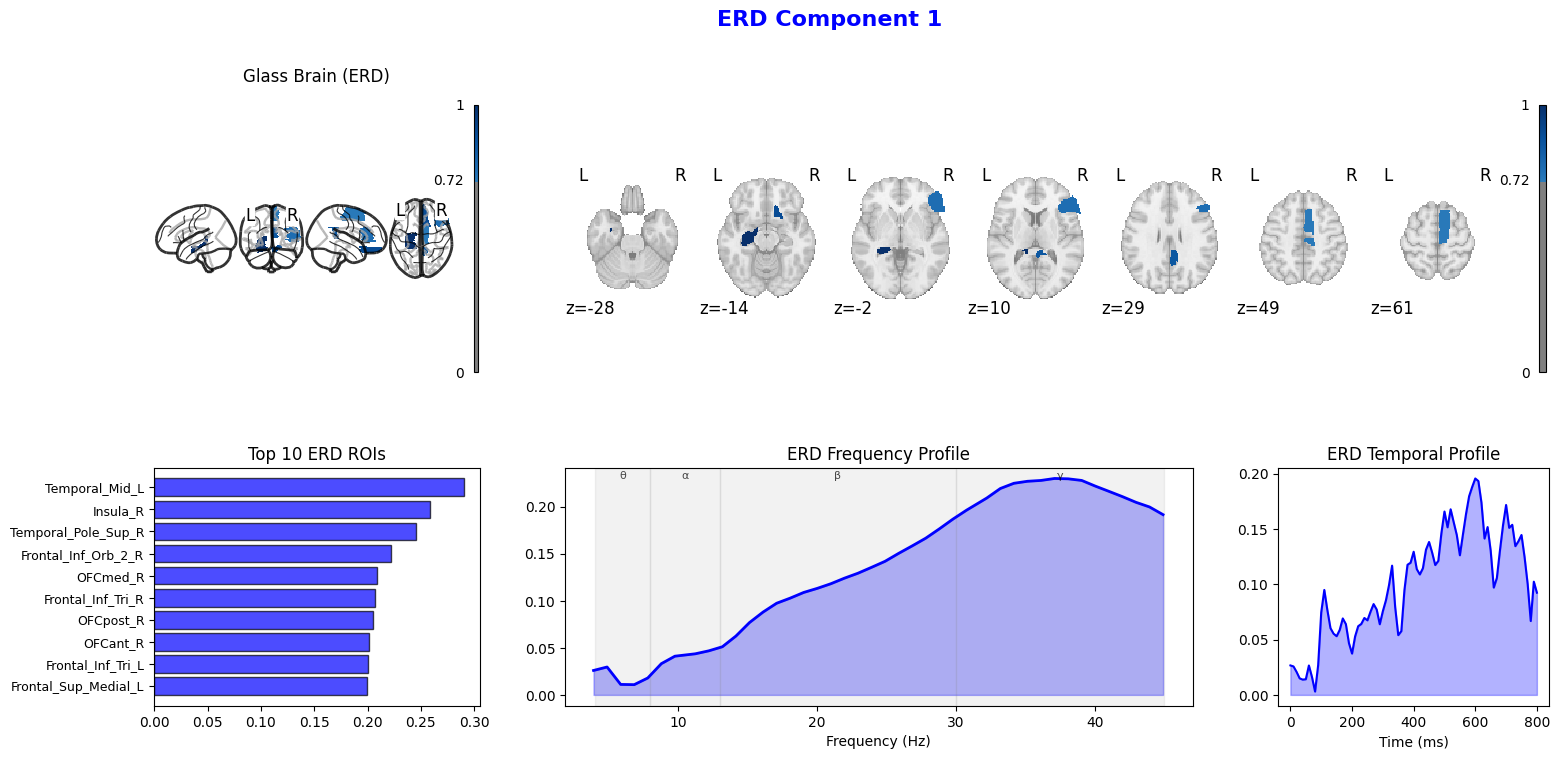

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


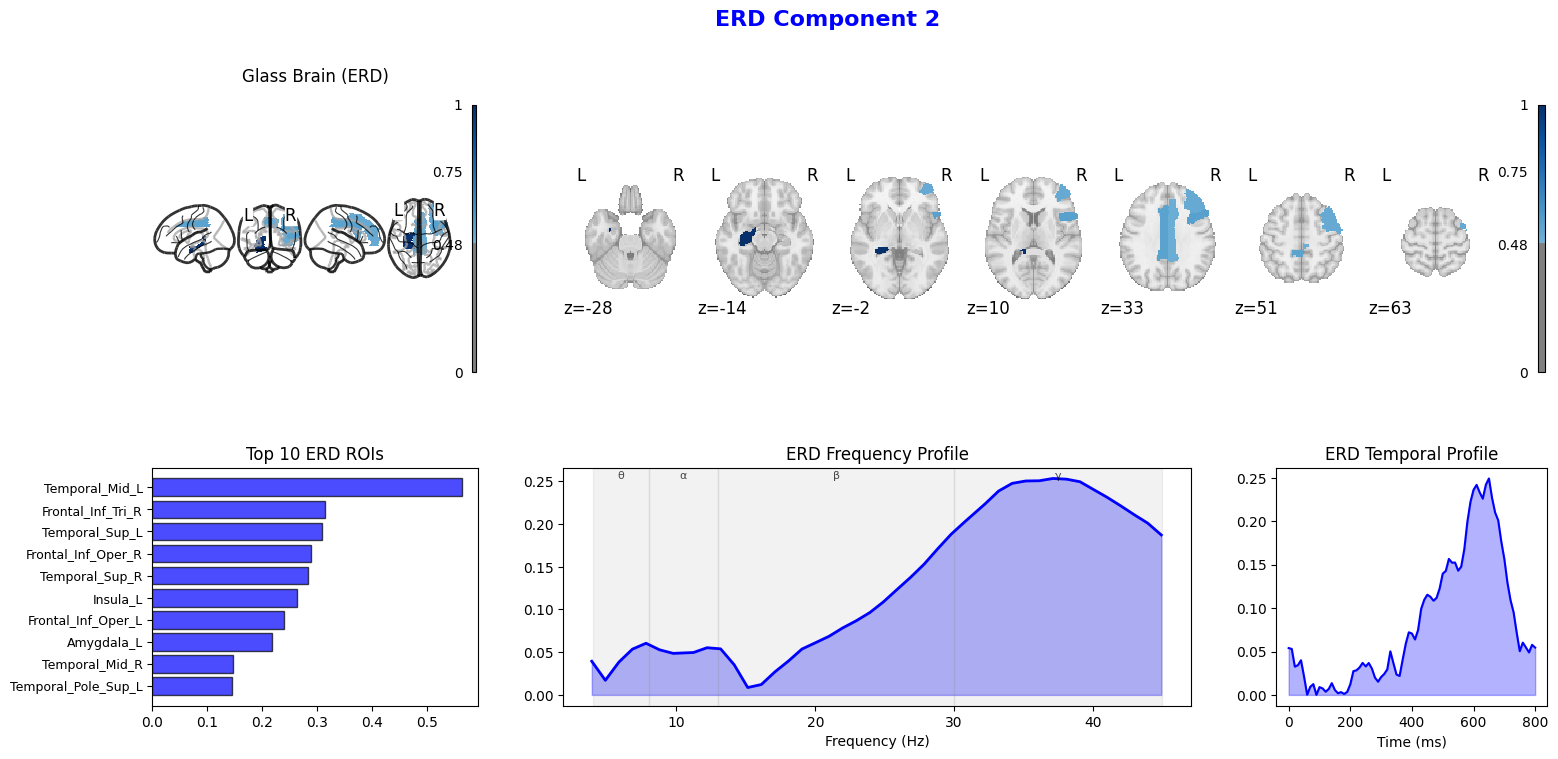

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


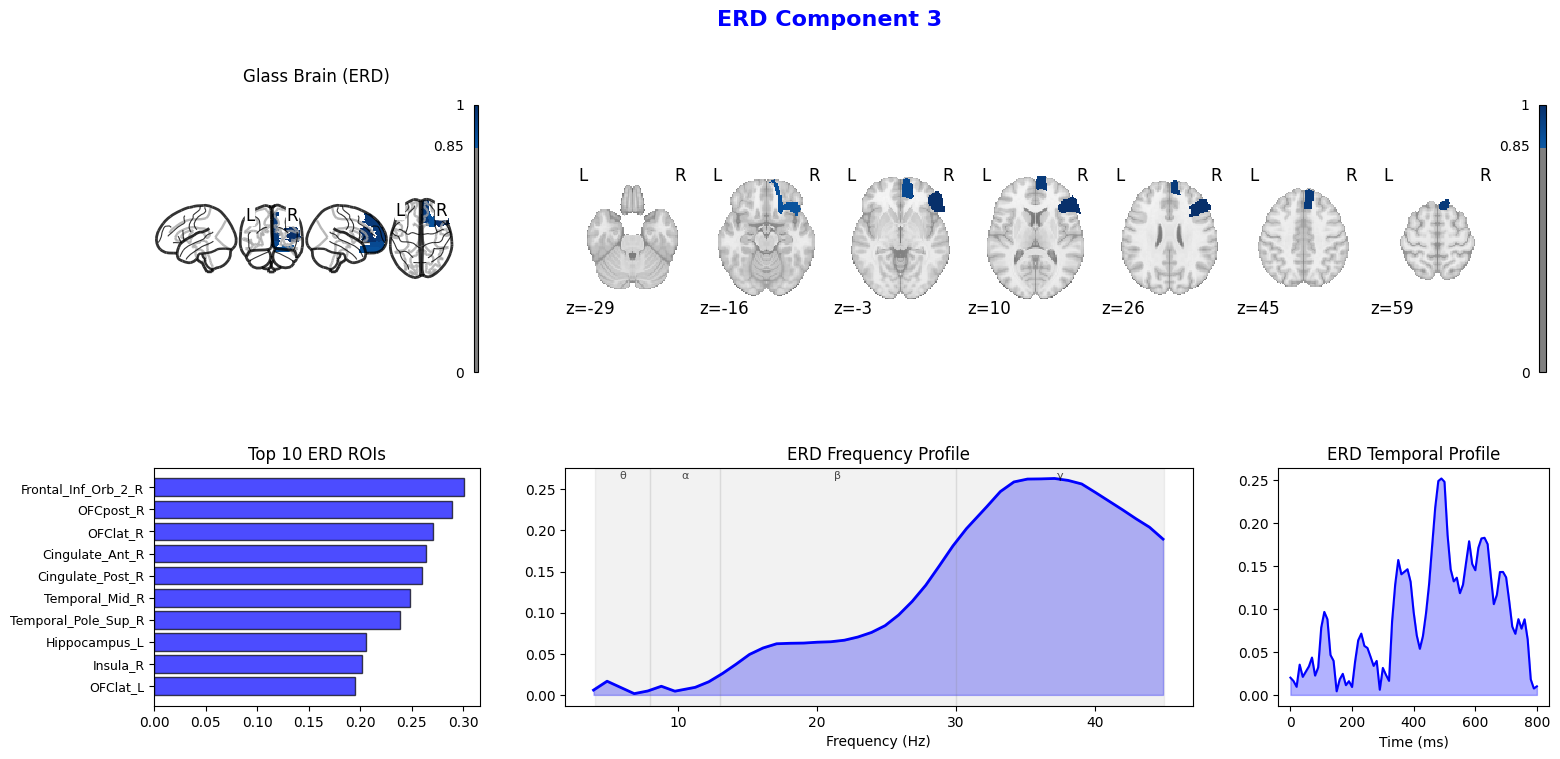

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


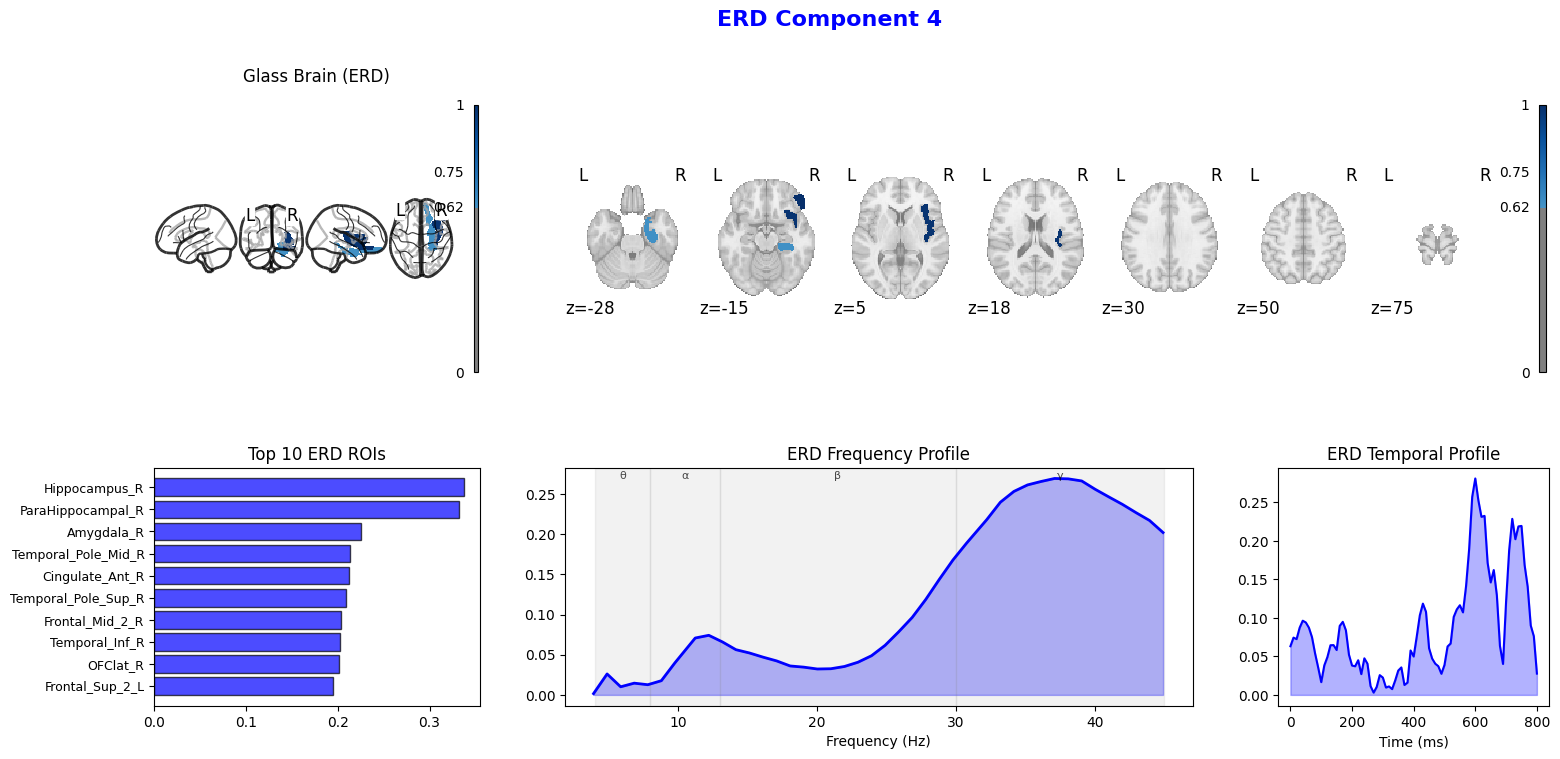

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


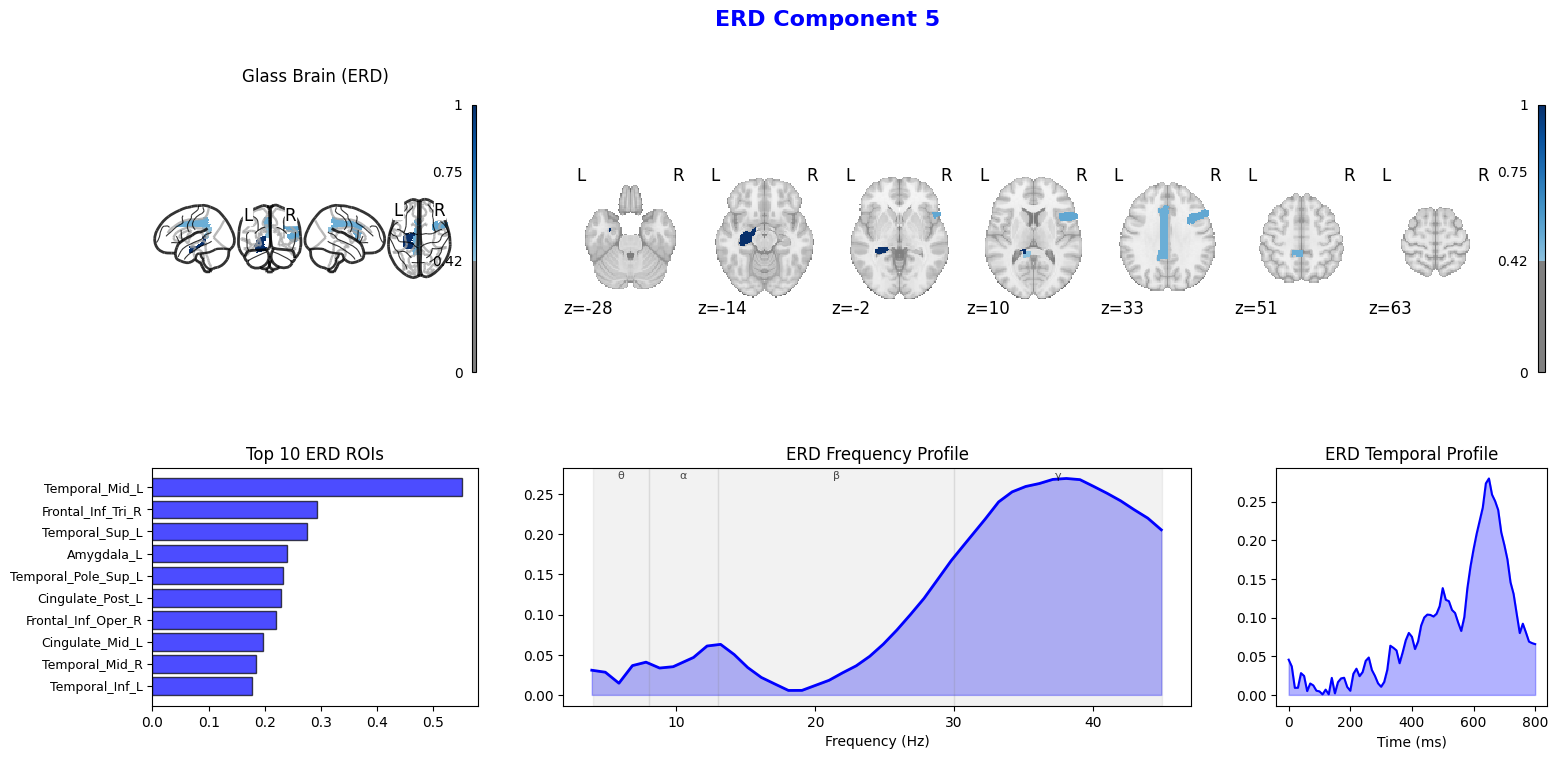

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


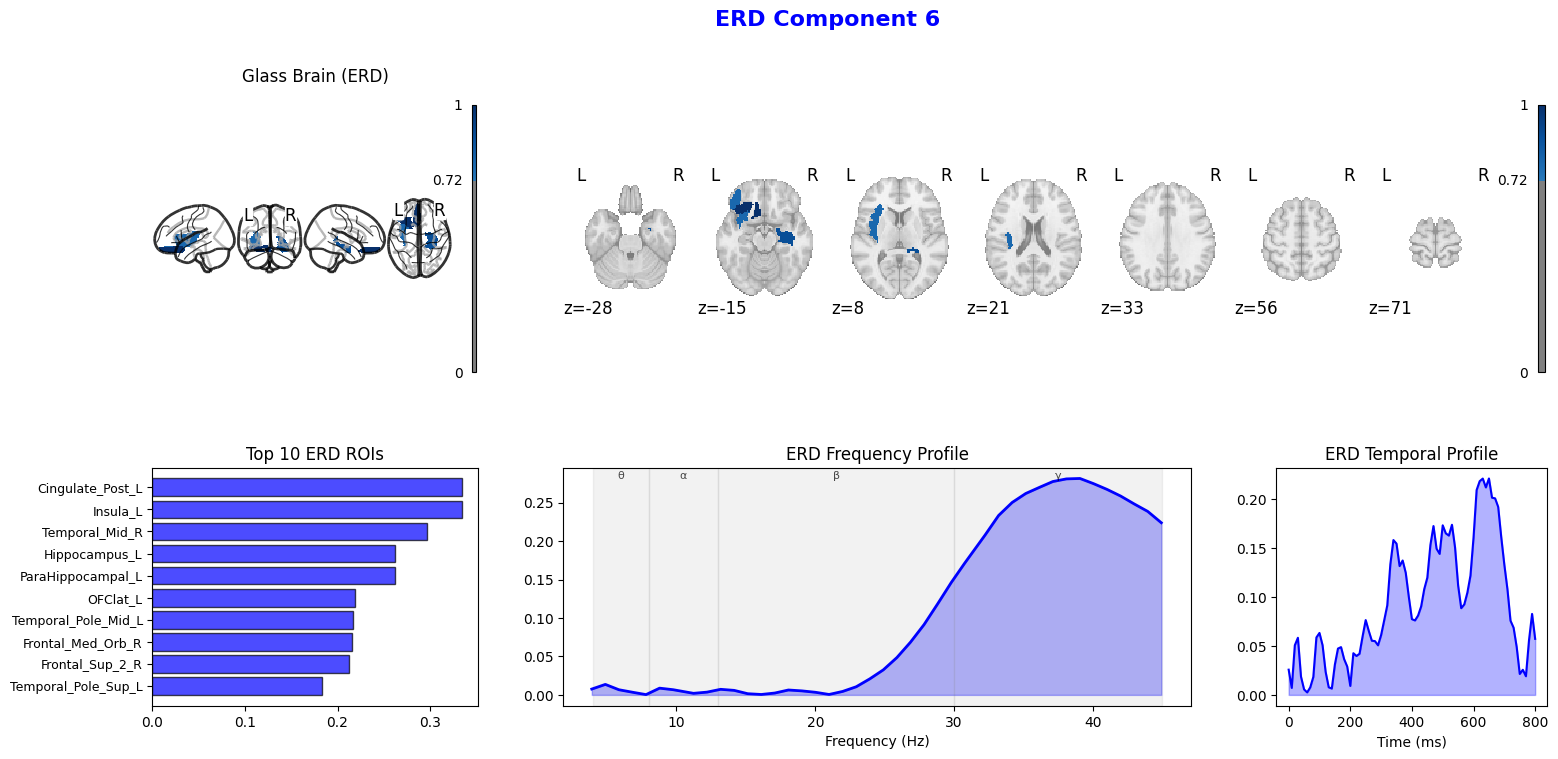

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


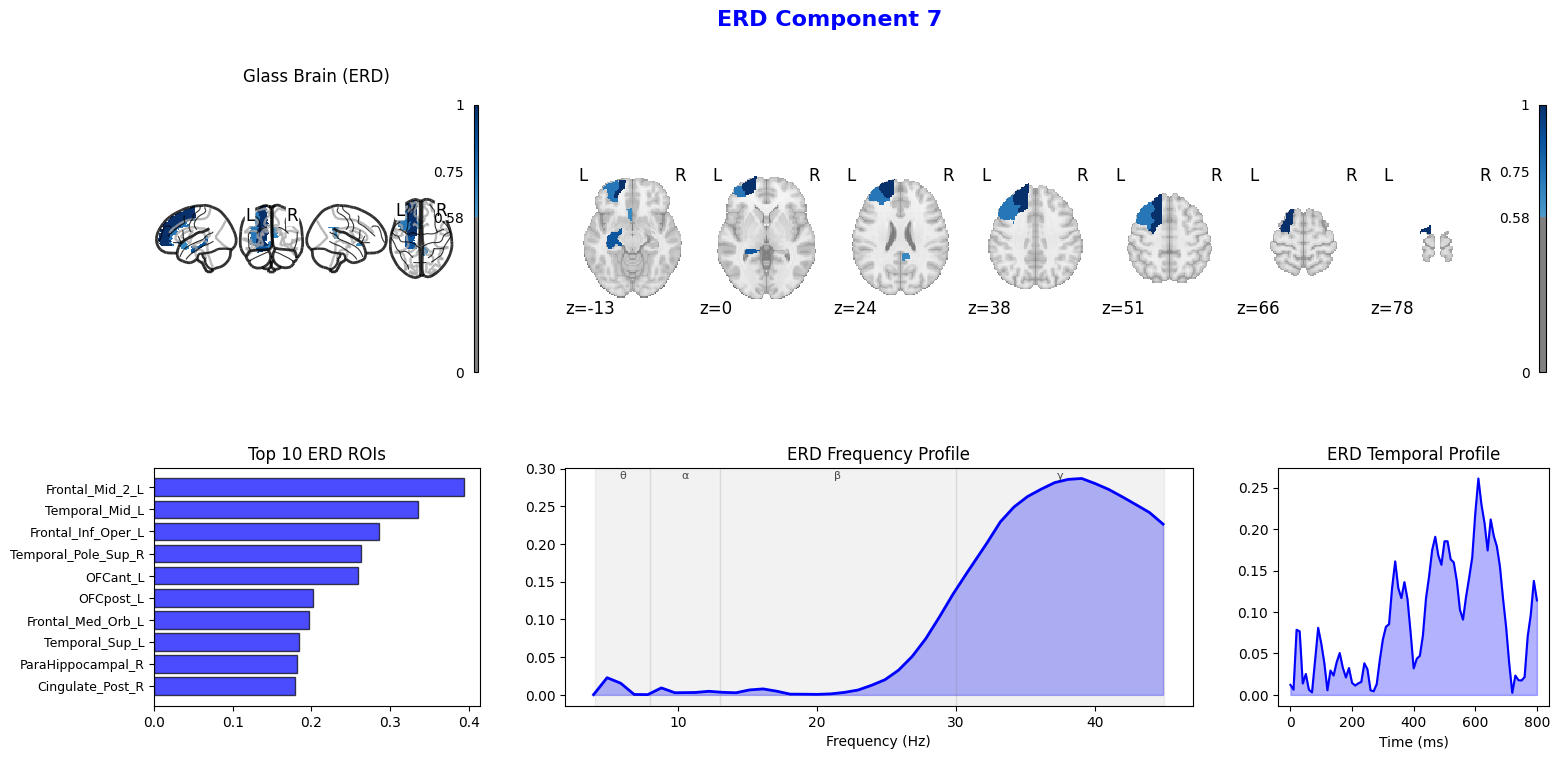

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


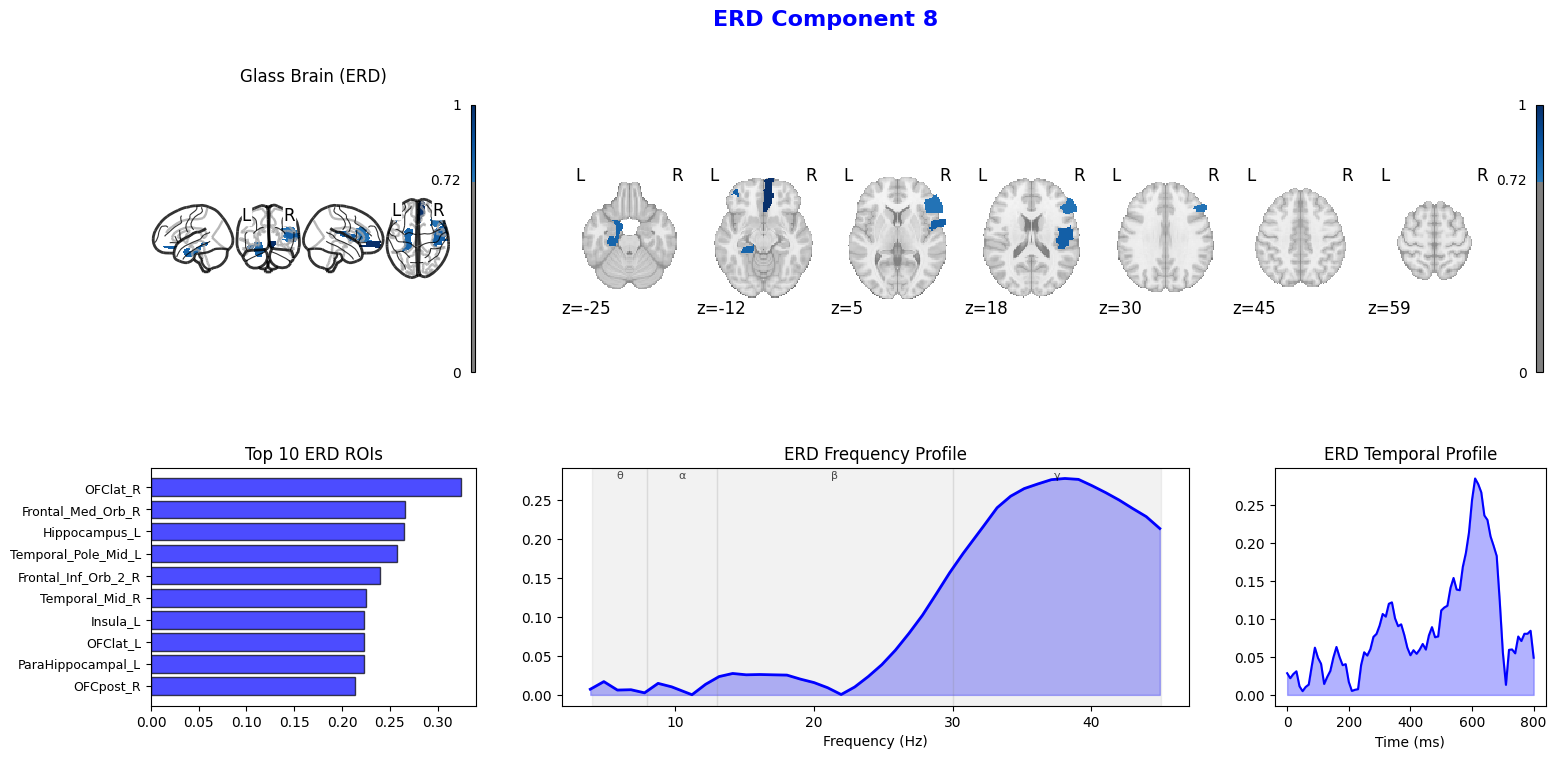

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


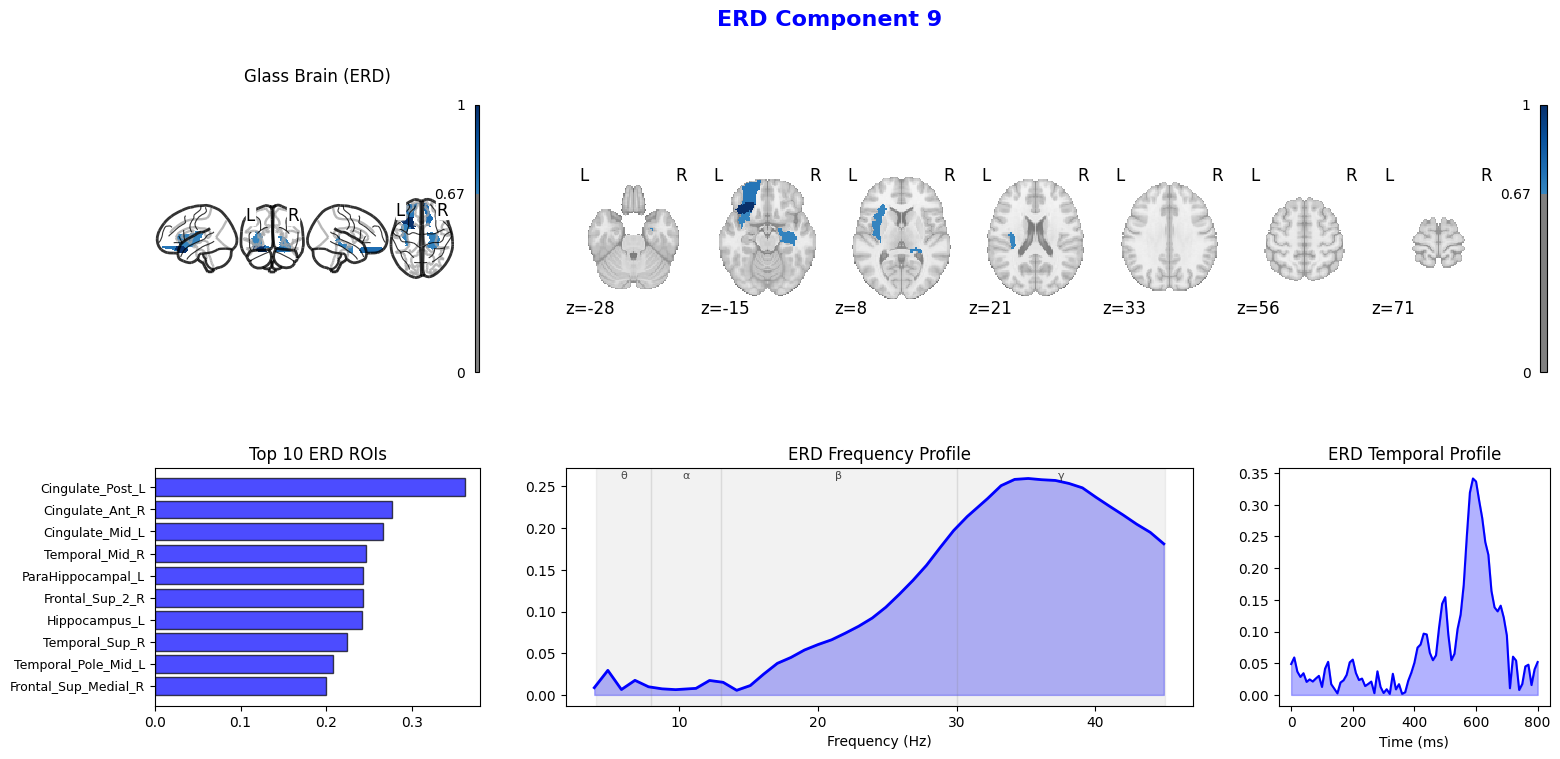

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


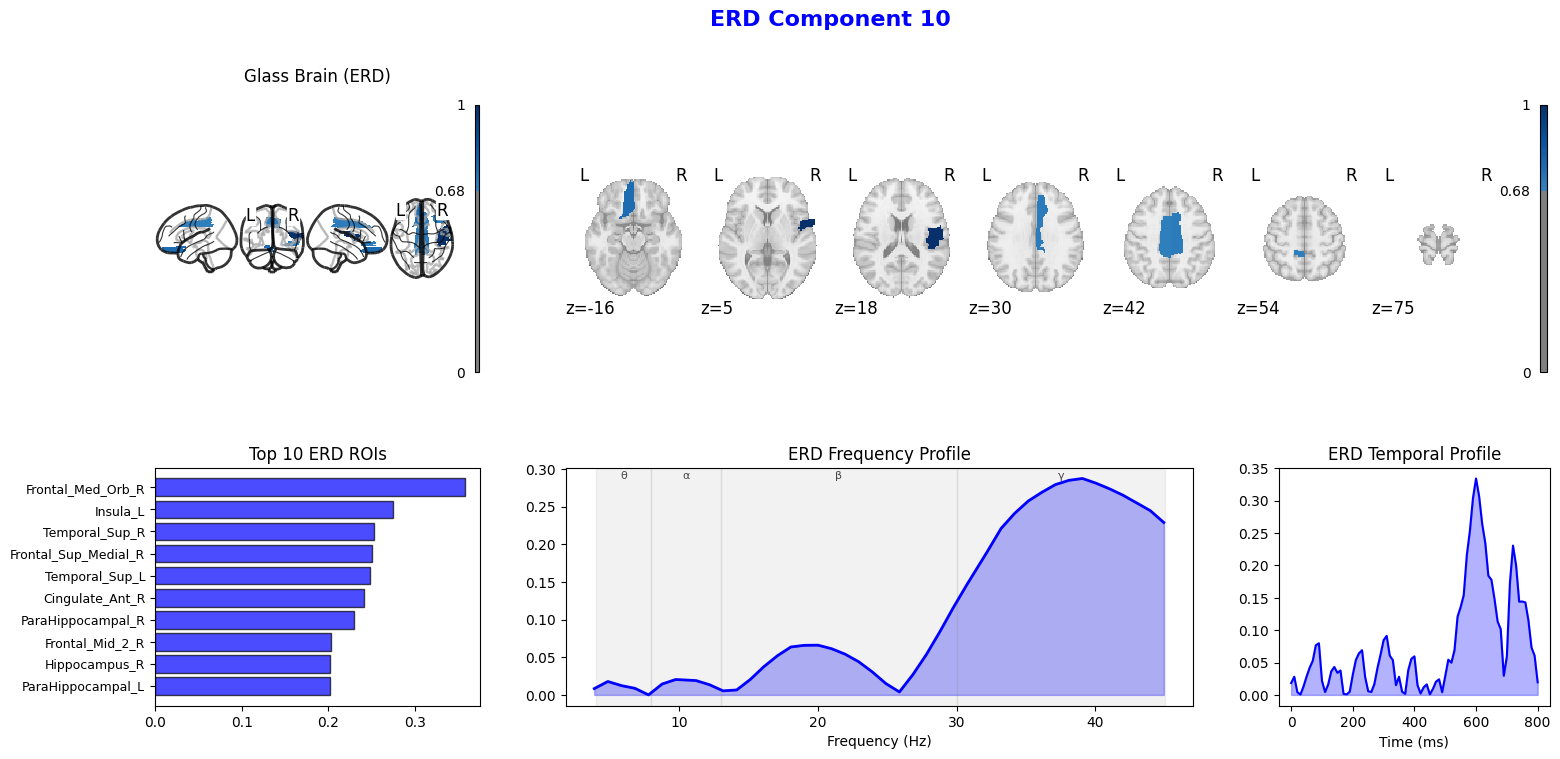

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


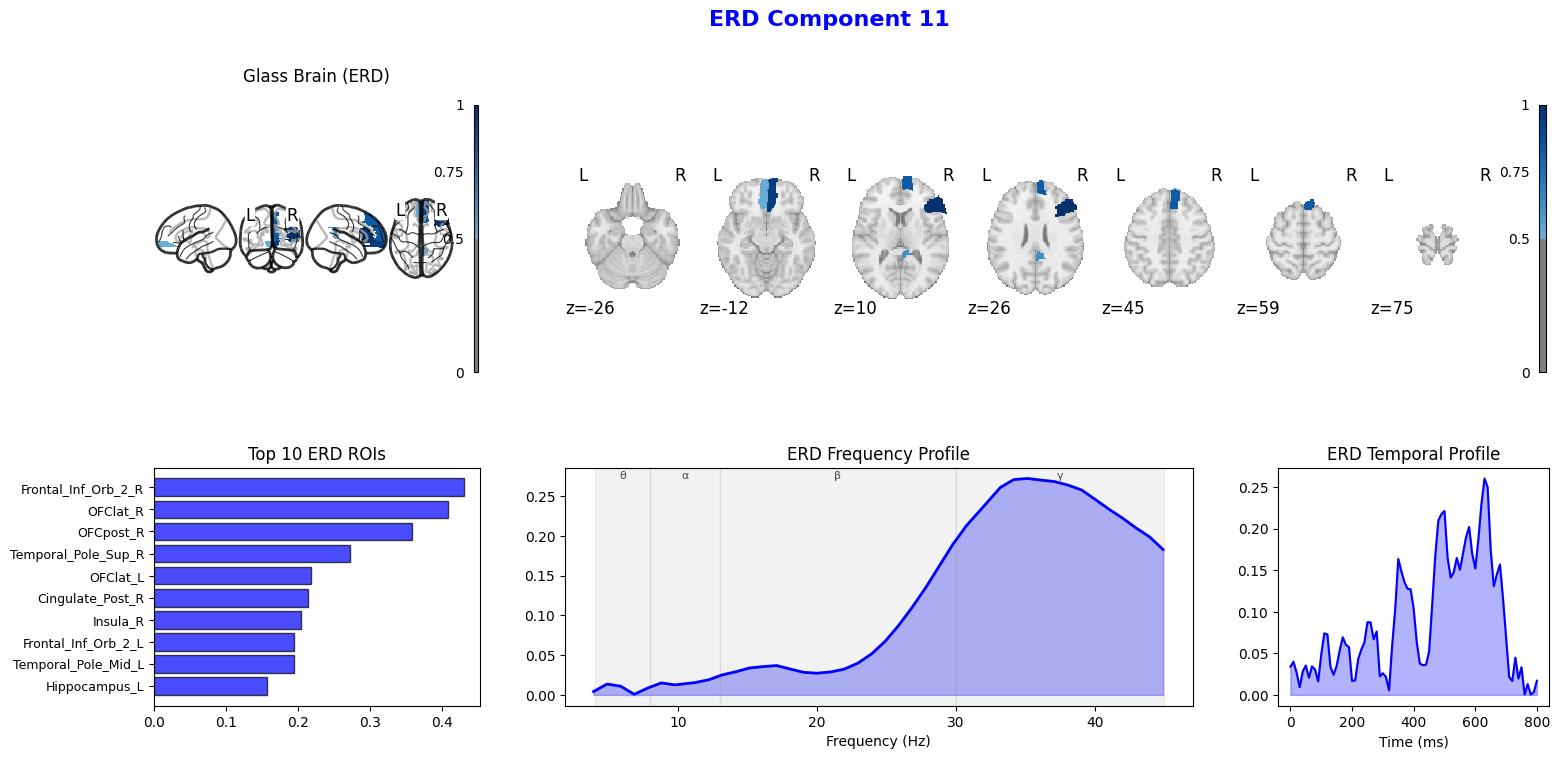

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


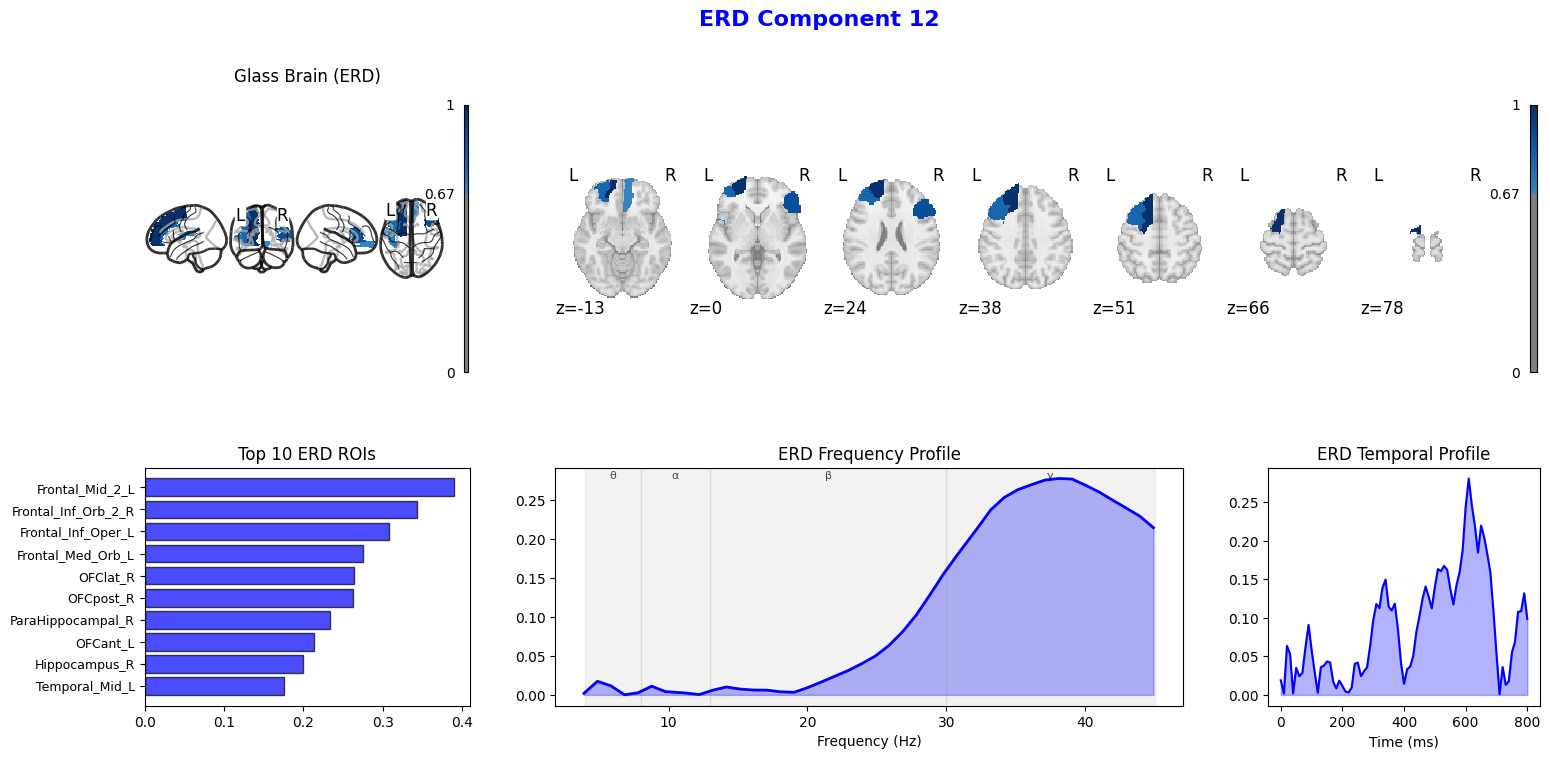

/tmp/ipython-input-1880607984.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


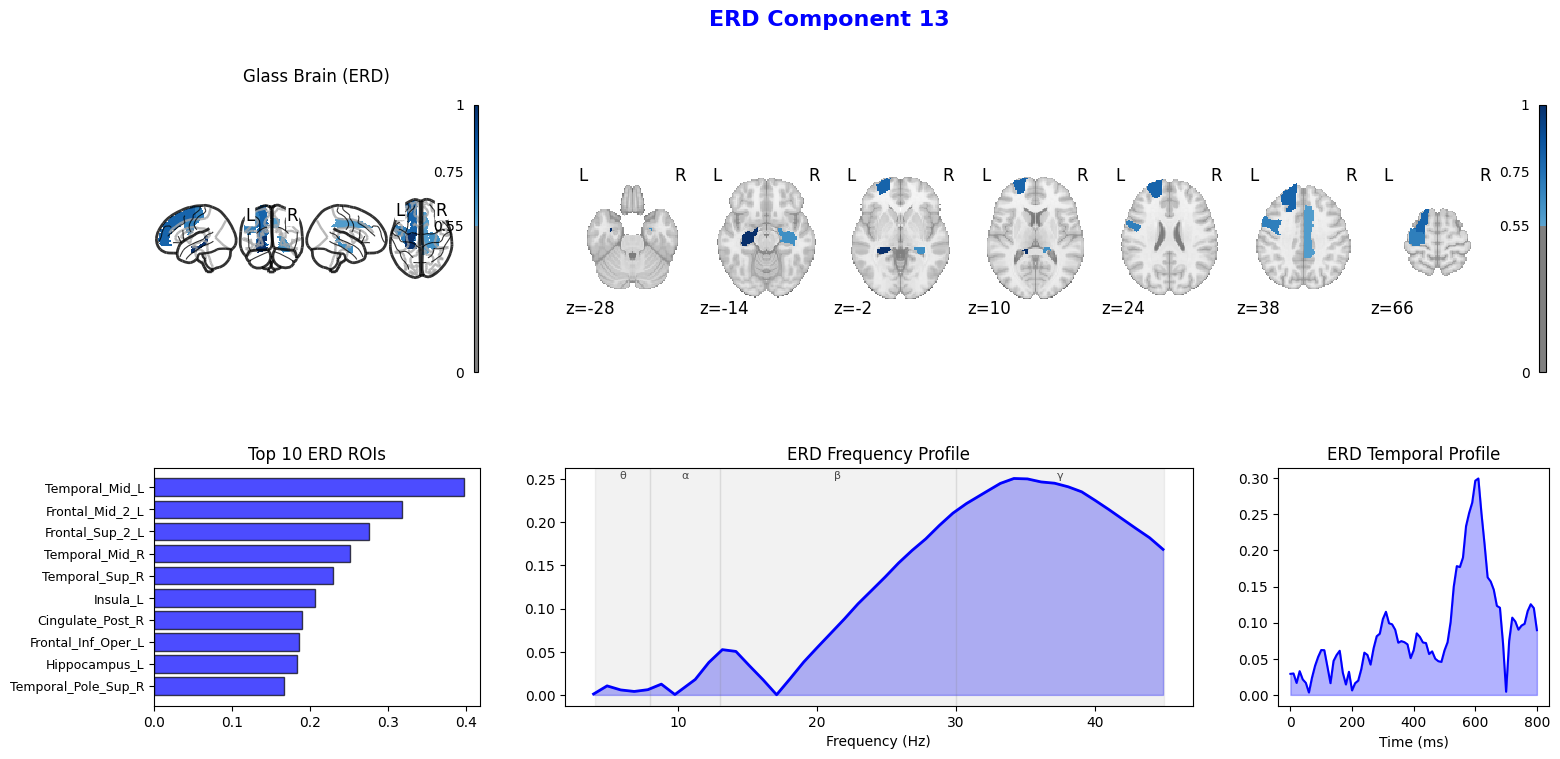

In [215]:
plot_factors_on_atlas_ers_erd(A_sorted, B_sorted, C_sorted, labels_filtered, labels_filtered, aal_nifti_path, freq_vec,time_vec, plot_type='ERD',threshold_percentile=90, save_fig=1,filename='outcome_alltrials_erd' )

In [213]:
r_squared(neg_pow_torch, cp_tensor_erd)

0.613434910774231